# Libs

In [ ]:
import csv
import pandas as pd
import sqlite3
import requests
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import holoviews as hv
from holoviews import opts


# U.S. Billboard Data (1960 - 2019) - Top 200 weekly

**Description:**
The dataset titled “acoustic_features” consists of *340,000* rows of acoustic data for tracks featured on Billboard 200 albums over a period spanning from *January 5th, 1963 to January 19th, 2019*.

**Extracted from:** https://components.one/datasets/billboard-200/

**Each row includes the following information:**


*   Track ID: Unique identifier for each track on Spotify.

*  Album Name: The album in which the track is featured.

* Artist Name: The artist or group performing the track.

**Acoustic Features:**

*  Acousticness: A measure of how acoustic the track is.

*  Danceability: How suitable the track is for dancing.

* Energy: The intensity and activity level of the track.

* Instrumentalness: The degree to which the track is instrumental.

* Liveness: The presence of a live audience or setting.

* Loudness: Overall loudness of the track in dB.

* Speechiness: The presence of spoken words in the track.

* Key: Musical key of the track.

* Time Signature: Beats per measure in the track.

* Valence: The musical positivity of the track.

* Duration (ms): Track length in milliseconds.

* Album ID: Unique identifier for the album on Spotify.

* Release Date: The release date of the album.

There are no null values in the original dataset, however, it's been appended with genres **from Spotify API** and hence, some null values are present in the added features.

**Added Features:**

'genres', 'artist_id', 'explicit', 'available_markets_count',
       'featured_track', 'featured_artists', 'year'

       
[defnitions to be added]


# Loading Initial Data

In [ ]:


conn = sqlite3.connect('billboard-200.db')
cursor = conn.cursor()

cursor.execute("SELECT * FROM 	acoustic_features")
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

with open('acoustic_features.csv', 'w',encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(columns)
    writer.writerows(rows)

conn.close()

In [ ]:
acoustic_features_df = pd.read_csv('acoustic_features.csv',encoding='ISO-8859-1')
acoustic_features_df.head()

id                                song       album  \
0  0Veyvc3n9AcLSoK3r1dA12                   Voices In My Head  Hoodie SZN   
1  77JzXZonNumWsuXKy9vr3U                              Beasty  Hoodie SZN   
2  18yllZD0TdF7ykcREib8Z1                            I Did It  Hoodie SZN   
3  1wJRveJZLSb1rjhnUHQiv6             Swervin (feat. 6ix9ine)  Hoodie SZN   
4  0jAfdqv18goRTUxm3ilRjb  Startender (feat. Offset and Tyga)  Hoodie SZN   

                   artist  acousticness  danceability  duration_ms  energy  \
0  A Boogie Wit da Hoodie        0.0555         0.754     142301.0   0.663   
1  A Boogie Wit da Hoodie        0.2920         0.860     152829.0   0.418   
2  A Boogie Wit da Hoodie        0.1530         0.718     215305.0   0.454   
3  A Boogie Wit da Hoodie        0.0153         0.581     189487.0   0.662   
4  A Boogie Wit da Hoodie        0.0235         0.736     192779.0   0.622   

   instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0          0.000000  6.0     0.101    -6.311   0.0        0.427   90.195   
1          0.000000  7.0     0.106    -9.061   0.0        0.158  126.023   
2          0.000046  8.0     0.116    -9.012   1.0        0.127   89.483   
3          0.000000  9.0     0.111    -5.239   1.0        0.303   93.023   
4          0.000000  6.0     0.151    -4.653   0.0        0.133  191.971   

   time_signature  valence                album_id        date  
0             4.0    0.207  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
1             4.0    0.374  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
2             4.0    0.196  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
3             4.0    0.434  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
4             4.0    0.506  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21

In [ ]:
acoustic_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339855 entries, 0 to 339854
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                339855 non-null  object 
 1   song              339852 non-null  object 
 2   album             339855 non-null  object 
 3   artist            339804 non-null  object 
 4   acousticness      339850 non-null  float64
 5   danceability      339850 non-null  float64
 6   duration_ms       339850 non-null  float64
 7   energy            339850 non-null  float64
 8   instrumentalness  339850 non-null  float64
 9   key               339850 non-null  float64
 10  liveness          339850 non-null  float64
 11  loudness          339850 non-null  float64
 12  mode              339850 non-null  float64
 13  speechiness       339850 non-null  float64
 14  tempo             339850 non-null  float64
 15  time_signature    339850 non-null  float64
 16  valence           33

# Data Extraction & Feature Enhancement

## Spotify API

In [ ]:

all_tracks_df = pd.DataFrame()



def get_token():
    client_id = ''
    client_secret = ''
    response = requests.post('https://accounts.spotify.com/api/token', data={
        'grant_type': 'client_credentials'
    }, auth=(client_id, client_secret))


    access_token = response.json()['access_token']
    return access_token

## Uncomment to get initial token

#token =  get_token()
#print(token)

def fetch_web_api(endpoint, method='GET', body=None):
    global token
    url = f'https://api.spotify.com/{endpoint}'
    headers = {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
    }

    response = requests.request(method, url, headers=headers, json=body)

    if response.status_code == 401:
        print('REAUTHENTICATING')
        response = requests.request(method, url, headers=headers, json=body)
    else:
     print(response.status_code)

    print(response)
    return response.json()




def get_album_info(id):
    endpoint = f'v1/albums/{id}'
    data = fetch_web_api(endpoint)
    pretty_json = json.dumps(data, indent=4)
    print(data['albums'][1])
    return data

def get_sevral_albums(albums_str):
    endpoint = f'v1/albums?ids={albums_str}'
    data = fetch_web_api(endpoint)
    # pretty_json = json.dumps(data, indent=4)
    # print(pretty_json)
    return data


def get_sevral_artists(artists_str):
    endpoint = f'v1/artists?ids={artists_str}'
    data = fetch_web_api(endpoint)
    return data


def get_artist_info(id):
    endpoint = f'v1/artists/{id}'
    data = fetch_web_api(endpoint)
    print(data)
    return data.get('items', [])





## LastFM Radio API

In [ ]:
import pylast

# You have to have your own unique two values for API_KEY and API_SECRET
# Obtain yours from https://www.last.fm/api/account/create for Last.fm

API_KEY = ""
API_SECRET = ""

# In order to perform a write operation you need to authenticate yourself
username = ""
password_hash = pylast.md5("")

network = pylast.LastFMNetwork(
    api_key=API_KEY,
    api_secret=API_SECRET,
    username=username,
    password_hash=password_hash,
)


def get_lastfm_genres(artist_name):
    url = 'http://ws.audioscrobbler.com/2.0/'
    params = {
        'method': 'artist.getInfo',
        'artist': artist_name,
        'api_key': API_KEY,
        'format': 'json'
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        tags = data['artist']['tags']['tag']
        genres = [tag['name'] for tag in tags]
        return ';'.join(genres) if genres else None
    except Exception:
        return None



def fill_missing_from_spotify(missing):
    try:
        for idx, row in missing.iterrows():

            artist_name = row['artist_name']  # or 'artist_name' — match your column
            genres = get_lastfm_genres(artist_name)
            print(idx,genres )
            if genres:
                missing.at[idx, 'genres'] = genres

    except Exception as e:
        print("Saving progress due to error...")
        missing.to_csv('artists_partial_genres.csv', index=False)
        raise e


## Data Parsing Functions

In [ ]:


## Parse JSON res from API Call

def split_artists_and_tracks(response):
    track_rows = []
    artist_rows = []
    try:
        for album in response['albums']:
            album_id = album['id']
            release_date = album.get('release_date')
            total_tracks = album.get('total_tracks')
            popularity = album.get('popularity', None)
            available_markets = len(album.get('available_markets', []))

            for track in album.get('tracks', {}).get('items', []):
                track_id = track['id']
                track_name = track['name']
                explicit = track['explicit']
                track_artists = track['artists']

                artist_names = ";".join([a['name'] for a in track_artists])
                artist_ids = ";".join([a['id'] for a in track_artists])

                track_rows.append({
                    'track_id': track_id,
                    'track_name': track_name,
                    'explicit': explicit,
                    'album_id': album_id,
                    'artist_names': artist_names,
                    'artist_ids': artist_ids,
                    'release_date': release_date,
                    'total_tracks': total_tracks,
                    'popularity': popularity,
                    'available_markets_count': available_markets,
                })

                for artist in track_artists:
                    artist_rows.append({
                        'artist_id': artist['id'],
                        'artist_name': artist['name']
                    })
    except Exception as e:
        print(f"Error while processing chunk {i}: {e}")

    tracks_df = pd.DataFrame(track_rows)
    artists_df = pd.DataFrame(artist_rows).drop_duplicates(subset='artist_id')

    return tracks_df, artists_df


## Utilizing the 50 albums/artists per call API thus the variable chunks


def parse_albums_response(chunks, artist_ids):
    for i, chunk in enumerate(chunks, start=1):
        print(f"Processing chunk {i}...")

        album_data = get_sevral_albums(chunk)
        chunk_df, chunk_artist_df = parse_albums_response(album_data)

        final_df = pd.concat([final_df, chunk_df], ignore_index=True)

        try:
            new_artists = chunk_artist_df[~chunk_artist_df['artist_id'].isin(list(artist_ids))]
            artist_ids.update(new_artists['artist_id'])
            artist_df = pd.concat([artist_df, new_artists], ignore_index=True)
           # artist_df.to_csv('spotify_artists3.csv', index=False)
        except Exception as e :
            print(e)
        #final_df.to_csv('spotify_tracks3.csv', index=False)

        time.sleep(2)    # Optional sleep to respect rate limits


def parse_artists_response(artist_chunks):
    for i, chunk in enumerate(artist_chunks[61:], start=62):
        print(f"Processing artist chunk {i}...")

        try:
            data = get_sevral_artists(chunk)
            artists = data['artists']


            parsed_chunk = []

            for artist in artists:
                artist_id = artist['id']
                artist_name = artist['name']
                followers = artist['followers']['total']
                genres = ';'.join(artist['genres'])

                parsed_chunk.append({
                    'artist_id': artist_id,
                    'artist_name': artist_name,
                    'genres': genres,
                    'followers': followers
                })

            chunk_df = pd.DataFrame(parsed_chunk)
            artist_info_df = pd.concat([artist_info_df, chunk_df], ignore_index=True)

            time.sleep(1)  # Respect rate limits

        except Exception as e:
            print(f"Error processing chunk {i}: {e}")
        #artist_info_df.to_csv('artists_info2.csv', index=False)

## Normalizing Genres

In [ ]:
def normalize_country(row):
    if 'country' in row['main_genre']:
        return pd.Series({
            'main_genre': 'country',
            'subgenre': row['main_genre'] if row['main_genre'] != 'country' else ''
        })
    else:
        return pd.Series({
            'main_genre': row['main_genre'],
            'subgenre': row.get('subgenre', '')  # keep existing subgenre if present
        })


def normalize_rock(row):
    if 'rock' in row['main_genre']:
        return pd.Series({
            'main_genre': 'rock',
            'subgenre': row['main_genre'] if row['main_genre'] != 'rock' else ''
        })
    else:
        return pd.Series({
            'main_genre': row['main_genre'],
            'subgenre': row.get('subgenre', '')
        })

def normalize_blues(row):
    if 'blues' in row['main_genre']:
        return pd.Series({
            'main_genre': 'blues',
            'subgenre': row['main_genre'] if row['main_genre'] != 'blues' else ''
        })
    else:
        return pd.Series({
            'main_genre': row['main_genre'],
            'subgenre': row.get('subgenre', '')
        })



def normalize_jazz(row):
    if 'jazz' in row['main_genre']:
        return pd.Series({
            'main_genre': 'jazz',
            'subgenre': row['main_genre'] if row['main_genre'] != 'jazz' else ''
        })
    else:
        return pd.Series({
            'main_genre': row['main_genre'],
            'subgenre': row.get('subgenre', '')
        })


def normalize_metal(row):
    genre = row['main_genre']
    if 'metal' in genre:
        return pd.Series({
            'main_genre': 'metal',
            'subgenre': genre if genre != 'metal' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row['subgenre'] if 'subgenre' in row else ''
        })

def normalize_soul(row):
    genre = row['main_genre']
    if 'soul' in genre:
        return pd.Series({
            'main_genre': 'soul',
            'subgenre': genre if genre != 'soul' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row['subgenre'] if 'subgenre' in row else ''
        })


def normalize_drill(row):
    genre = row['main_genre']
    if 'drill' in genre:
        return pd.Series({
            'main_genre': 'hip hop',
            'subgenre': genre
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row['subgenre'] if 'subgenre' in row else ''
        })

def normalize_grunge(row):
    genre = row['main_genre']
    if 'grunge' in genre:
        return pd.Series({
            'main_genre': 'rock',
            'subgenre': genre
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row['subgenre'] if 'subgenre' in row else ''
        })
def normalize_edm(row):
    genre = row['main_genre']
    if 'house' in genre or 'edm' in genre:
        return pd.Series({
            'main_genre': 'edm',
            'subgenre': genre if genre != 'edm' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row['subgenre'] if 'subgenre' in row else ''
        })

# Apply the function

def normalize_punk(row):
    genre = row['main_genre']
    if 'punk' in genre:
        return pd.Series({
            'main_genre': 'punk',
            'subgenre': genre if genre != 'punk' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row['subgenre'] if 'subgenre' in row else ''
        })

# 🎼 Normalize R&B
def normalize_rnb(row):
    genre = row['main_genre'].lower()
    if 'r&b' in genre or 'rnb' in genre:
        return pd.Series({
            'main_genre': 'r&b',
            'subgenre': genre if genre != 'r&b' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🎧 Normalize EDM / Electronic
def normalize_electronic(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['edm', 'house', 'techno', 'trance', 'electro', 'dubstep', 'bass', 'drum and bass', 'future bass', 'lo-fi', 'electronica']):
        return pd.Series({
            'main_genre': 'edm',
            'subgenre': genre if genre != 'edm' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🪘 Normalize Latin
def normalize_latin(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['latin', 'reggaeton', 'mpb', 'urbano', 'banda', 'salsa']):
        return pd.Series({
            'main_genre': 'latin',
            'subgenre': genre if genre != 'latin' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🪕 Normalize Folk
def normalize_folk(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['folk', 'bluegrass', 'americana', 'celtic']):
        return pd.Series({
            'main_genre': 'folk',
            'subgenre': genre if genre != 'folk' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🧠 Normalize Experimental
def normalize_experimental(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['avant-garde', 'idm', 'glitch', 'drone', 'noise', 'experimental']):
        return pd.Series({
            'main_genre': 'experimental',
            'subgenre': genre if genre != 'experimental' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🕌 Normalize Gospel / Christian
def normalize_gospel(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['gospel', 'worship', 'ccm', 'christian', 'pentecostal', 'devotional', 'african gospel']):
        return pd.Series({
            'main_genre': 'gospel',
            'subgenre': genre if genre != 'gospel' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🪩 Normalize Disco / Dance
def normalize_disco(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['disco', 'dancehall', 'boogie', 'nu disco', 'post-disco', 'eurodance']):
        return pd.Series({
            'main_genre': 'disco',
            'subgenre': genre if genre != 'disco' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🎭 Normalize Classical / Musicals / Opera
def normalize_classical_vocal(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['opera', 'musicals', 'choral', 'orchestra', 'classical']):
        return pd.Series({
            'main_genre': 'classical',
            'subgenre': genre if genre != 'classical' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🎄 Normalize Holiday
def normalize_holiday(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['christmas', 'holiday', 'carols']):
        return pd.Series({
            'main_genre': 'holiday',
            'subgenre': genre if genre != 'holiday' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# 🤘 Normalize Hardcore / Screamo
def normalize_hardcore(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in ['hardcore', 'post-hardcore', 'screamo', 'deathcore', 'grindcore']):
        return pd.Series({
            'main_genre': 'hardcore',
            'subgenre': genre if genre != 'hardcore' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })


def normalize_world(row):
    genre = row['main_genre'].lower()
    if any(term in genre for term in [
        'afrobeat', 'afrobeats', 'bossa nova', 'samba', 'cumbia', 'ragga', 'calypso', 'ska',
        'reggae', 'roots reggae', 'dub', 'mariachi', 'duranguense', 'tejano', 'grupera',
        'norteño', 'bachata', 'bolero', 'flamenco', 'bhangra', 'qawwali', 'sufi', 'tango',
        'gnawa', 'folk', 'traditional music', 'zouk', 'axé', 'mizrahi', 'raï', 'kundiman',
        'sertanejo', 'gufeng', 'timba', 'chanson', 'iskelmä', 'canzone napoletana',
        'tollywood', 'mollywood', 'bollywood', 'tamil indie', 'malay', 'visual kei',
        'japanese classical', 'spanish-language reggae', 'cumbia norteña', 'neoperreo',
        'latin indie', 'latin afrobeat', 'latin alternative', 'latin folk'
    ]):
        return pd.Series({
            'main_genre': 'world',
            'subgenre': genre if genre != 'world' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

def normalize_synth_to_pop(row):
    genre = row['main_genre'].lower()
    if 'synthwave' in genre or 'synthpop' in genre:
        return pd.Series({
            'main_genre': 'pop',
            'subgenre': genre if genre != 'pop' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })


def normalize_any_pop(row):
    genre = row['main_genre'].lower()
    if 'pop' in genre:
        return pd.Series({
            'main_genre': 'pop',
            'subgenre': genre if genre != 'pop' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })



def normalize_step_to_edm(row):
    genre = row['main_genre'].lower()
    if 'step' in genre:
        return pd.Series({
            'main_genre': 'edm',
            'subgenre': genre if genre != 'edm' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

def normalize_funk(row):
    genre = row['main_genre'].lower()
    if 'funk' in genre:
        return pd.Series({
            'main_genre': 'funk',
            'subgenre': genre if genre != 'funk' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })


def normalize_swing(row):
    genre = row['main_genre'].lower()
    if 'swing' in genre:
        return pd.Series({
            'main_genre': 'swing',
            'subgenre': genre if genre != 'swing' else ''
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })

# ✅ Apply all normalization functions
# for func in [
#     normalize_rnb,
#     normalize_electronic,
#     normalize_latin,
#     normalize_folk,
#     normalize_experimental,
#     normalize_gospel,
#     normalize_disco,
#     normalize_classical_vocal,
#     normalize_holiday,
#     normalize_hardcore
# ]:
#     spotify_artists_df[['main_genre', 'subgenre']] = spotify_artists_df.apply(func, axis=1)

#spotify_artists_df[['main_genre', 'subgenre']] = spotify_artists_df.apply(normalize_swing, axis=1)
# spotify_artists_df[['main_genre', 'subgenre']] = spotify_artists_df.apply(normalize_drill, axis=1)

# Apply the function
#spotify_artists_df[['main_genre', 'subgenre']] = spotify_artists_df.apply(normalize_blues, axis=1)

#spotify_artists_df[['main_genre', 'subgenre']] = spotify_artists_df.apply(normalize_country, axis=1)
#spotify_artists_df[['main_genre', 'subgenre']] = spotify_artists_df.apply(normalize_rock, axis=1)


In [ ]:
genre_mapping = {
    # EDM / Electronic
    'crunk': 'edm',
    'ballroom vogue': 'edm',
    'uk garage': 'edm',
    'breakbeat': 'edm',
    'big room': 'edm',
    'moombahton': 'edm',
    'hardstyle': 'edm',
    'chillwave': 'edm',
    'alternative dance': 'edm',
    'soca': 'edm',
    'baltimore club': 'edm',
    'jungle': 'edm',
    'bounce': 'edm',
    'melbourne bounce': 'edm',
    'italo dance': 'edm',
    'downtempo': 'edm',
    'dembow': 'edm',
    'trap': 'edm',
    'darkwave': 'edm',
    'nightcore': 'edm',
    'speedcore': 'edm',
    'new rave': 'edm',
    'footwork': 'edm',
    'gabber': 'edm',
    'jersey club': 'edm',
    'frenchcore': 'edm',
    'ambient': 'edm',
    'industrial': 'edm',

    # World / Latin / Regional
    'kizomba': 'world',
    'merengue': 'world',
    'bhajan': 'world',
    'kuduro': 'world',
    'ghazal': 'world',
    'champeta': 'world',
    'gengetone': 'world',
    'mexican indie': 'world',
    'gqom': 'world',
    'azonto': 'world',
    'música mexicana': 'world',
    'sea shanties': 'world',
    'trova': 'world',
    'honky tonk': 'world',
    'enka': 'world',
    'dansband': 'world',
    'brega': 'world',
    'phleng phuea chiwit': 'world',
    'polka': 'world',
    'son cubano': 'world',
    'gujarati garba': 'world',
    'red dirt': 'world',
    'swedish ballads': 'world',

    # Rock / Alternative
    'emo': 'rock',
    'madchester': 'rock',
    'dark cabaret': 'rock',
    'shoegaze': 'rock',
    'midwest emo': 'rock',
    'slowcore': 'rock',
    'cold wave': 'rock',
    'psychobilly': 'rock',

    # Pop
    'easy listening': 'pop',
    'italian singer-songwriter': 'pop',
    'schlager': 'pop',
    'opm': 'pop',
    'lounge': 'pop',
    'vocaloid': 'pop',

    # Classical / Vocal
    'chamber music': 'classical',
    'requiem': 'classical',
    'gregorian chant': 'classical',
    'medieval': 'classical',
    'bebop': 'classical',
    'hard bop': 'classical',
    'entehno': 'classical',

    # Other niche
    'nerdcore': 'hip hop',
    'anime': 'soundtrack',
    'lullaby': 'children',
    'variété française': 'pop',
    'dark trap': 'edm',
    'russelåter': 'pop',
    'alté': 'pop',

    #rock

    'punk': 'rock',
    'hardcore': 'rock',
    #soul

    'doo-wop': 'soul',
    'motown': 'soul',
    'hyphy':'hip hop',
    'go-go':'disco',
    'boom bap':'hip hop',
    'riddim':'edm',
    'hi-nrg':'disco',
    'big beat':'edm',
    'neue deutsche welle':'world',
    r"children's music" : 'children',
    'cloud rap':'hip hop',
    'gangster rap':'hip hop',
    'k-rap':'hip hop',
    'rage rap':'hip hop',
    'j-rap':'hip hop',
    'emo rap':'hip hop',
    'memphis rap':'hip hop',
    'melodic rap':'hip hop',
    'rap':'hip hop'
}


def normalize_to_suggested(row):
    genre = row['main_genre'].lower()
    if genre in genre_mapping:
        return pd.Series({
            'main_genre': genre_mapping[genre],
            'subgenre': genre
        })
    else:
        return pd.Series({
            'main_genre': genre,
            'subgenre': row.get('subgenre', '')
        })



# EDA

In [ ]:
df = acoustic_features_df

df.head()

id                                song       album  \
0  0Veyvc3n9AcLSoK3r1dA12                   Voices In My Head  Hoodie SZN   
1  77JzXZonNumWsuXKy9vr3U                              Beasty  Hoodie SZN   
2  18yllZD0TdF7ykcREib8Z1                            I Did It  Hoodie SZN   
3  1wJRveJZLSb1rjhnUHQiv6             Swervin (feat. 6ix9ine)  Hoodie SZN   
4  0jAfdqv18goRTUxm3ilRjb  Startender (feat. Offset and Tyga)  Hoodie SZN   

                   artist  acousticness  danceability  duration_ms  energy  \
0  A Boogie Wit da Hoodie        0.0555         0.754     142301.0   0.663   
1  A Boogie Wit da Hoodie        0.2920         0.860     152829.0   0.418   
2  A Boogie Wit da Hoodie        0.1530         0.718     215305.0   0.454   
3  A Boogie Wit da Hoodie        0.0153         0.581     189487.0   0.662   
4  A Boogie Wit da Hoodie        0.0235         0.736     192779.0   0.622   

   instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0          0.000000  6.0     0.101    -6.311   0.0        0.427   90.195   
1          0.000000  7.0     0.106    -9.061   0.0        0.158  126.023   
2          0.000046  8.0     0.116    -9.012   1.0        0.127   89.483   
3          0.000000  9.0     0.111    -5.239   1.0        0.303   93.023   
4          0.000000  6.0     0.151    -4.653   0.0        0.133  191.971   

   time_signature  valence                album_id        date  
0             4.0    0.207  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
1             4.0    0.374  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
2             4.0    0.196  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
3             4.0    0.434  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21  
4             4.0    0.506  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21

In [ ]:
df_clean_genres = pd.read_csv('latest_clean_genres.csv')
df = pd.read_csv('acoustic_features_data.csv')

df_no_genres = df.drop(columns=['genres'])

# Step 2: Select only necessary columns from df_clean_genres
df_genres_selected = df_clean_genres[['artist_id', 'main_genre', 'subgenre']].drop_duplicates(subset=['artist_id'])

# Step 3: Merge both DataFrames on 'artist_id'
trial_df = df.merge(df_genres_selected, on='artist_id', how='left')

trial_df.head()

id                                song       album  \
0  0Veyvc3n9AcLSoK3r1dA12                   Voices In My Head  Hoodie SZN   
1  77JzXZonNumWsuXKy9vr3U                              Beasty  Hoodie SZN   
2  18yllZD0TdF7ykcREib8Z1                            I Did It  Hoodie SZN   
3  1wJRveJZLSb1rjhnUHQiv6             Swervin (feat. 6ix9ine)  Hoodie SZN   
4  0jAfdqv18goRTUxm3ilRjb  Startender (feat. Offset and Tyga)  Hoodie SZN   

              artist_name  acousticness  danceability  duration_ms  energy  \
0  A Boogie Wit da Hoodie        0.0555         0.754     142301.0   0.663   
1  A Boogie Wit da Hoodie        0.2920         0.860     152829.0   0.418   
2  A Boogie Wit da Hoodie        0.1530         0.718     215305.0   0.454   
3  A Boogie Wit da Hoodie        0.0153         0.581     189487.0   0.662   
4  A Boogie Wit da Hoodie        0.0235         0.736     192779.0   0.622   

   instrumentalness  key  ...                album_id        date  \
0          0.000000  6.0  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21   
1          0.000000  7.0  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21   
2          0.000046  8.0  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21   
3          0.000000  9.0  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21   
4          0.000000  6.0  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21   

        genres               artist_id  explicit  available_markets_count  \
0  melodic rap  31W5EY0aAly4Qieq6OFu6I      True                    185.0   
1  melodic rap  31W5EY0aAly4Qieq6OFu6I      True                    185.0   
2  melodic rap  31W5EY0aAly4Qieq6OFu6I      True                    185.0   
3  melodic rap  31W5EY0aAly4Qieq6OFu6I      True                    185.0   
4  melodic rap  31W5EY0aAly4Qieq6OFu6I      True                    185.0   

   featured_track                               featured_artists main_genre  \
0           False                                            NaN    hip hop   
1           False                                            NaN    hip hop   
2           False                                            NaN    hip hop   
3            True                         7gZfnEnfiaHzxARJ2LeXrf    hip hop   
4            True  5LHRHt1k9lMyONurDHEdrp;4DdkRBBYG6Yk9Ka8tdJ9BW    hip hop   

  subgenre  
0      rap  
1      rap  
2      rap  
3      rap  
4      rap  

[5 rows x 27 columns]

# Nadeen

#Analysis Objectives - Genre Evolution Analysis:

Track the evolution of popular genres over time to identify trends, such as:

1. Which genres have gained or lost popularity over the decades.

2. The rise and decline of specific genres (e.g., Disco in the 1970s, Hip-Hop in the 1990s).

3. Identifying genre shifts in response to cultural or technological changes.

In [ ]:
# Count and percentage of missing values
missing_main = trial_df['main_genre'].isna().sum()
missing_sub = trial_df['subgenre'].isna().sum()

total_rows = len(trial_df)

print(f"Missing 'main_genre': {missing_main} ({(missing_main / total_rows) * 100:.2f}%)")
print(f"Missing 'subgenre'  : {missing_sub} ({(missing_sub / total_rows) * 100:.2f}%)")


Missing 'main_genre': 47118 (13.86%)
Missing 'subgenre'  : 47248 (13.90%)


In [ ]:
#lower case column names
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'song', 'album', 'artist_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'album_id', 'date', 'genres', 'artist_id', 'explicit',
       'available_markets_count', 'featured_track', 'featured_artists'],
      dtype='object')

Adding year and decade as features from date

In [ ]:
# Identify string rows
is_str = trial_df['date'].apply(lambda x: isinstance(x, str))

# Parse only the strings using mixed format
trial_df.loc[is_str, 'date'] = pd.to_datetime(
    trial_df.loc[is_str, 'date'],
    format='mixed',
    errors='coerce'  # or 'raise' if you want to debug bad values
)


In [ ]:
# Now ensure the column is all datetime type
trial_df['date'] = pd.to_datetime(trial_df['date'], errors='coerce')


In [ ]:
trial_df['year'] = trial_df['date'].dt.year.astype('Int64')
trial_df['decade'] = (trial_df['year'] // 10 * 10).astype('Int64')


In [ ]:
# prompt: check missing in year, decade, and date

# Check for missing values in 'year', 'decade', and 'date'
missing_year = trial_df['year'].isna().sum()
missing_decade = trial_df['decade'].isna().sum()
missing_date = trial_df['date'].isna().sum()

total_rows = len(trial_df)

print(f"Missing 'year': {missing_year} ({(missing_year / total_rows) * 100:.2f}%)")
print(f"Missing 'decade': {missing_decade} ({(missing_decade / total_rows) * 100:.2f}%)")
print(f"Missing 'date': {missing_date} ({(missing_date / total_rows) * 100:.2f}%)")

Missing 'year': 0 (0.00%)
Missing 'decade': 0 (0.00%)
Missing 'date': 0 (0.00%)


In [ ]:
# prompt: scale tempo from 0 to 1

from sklearn.preprocessing import MinMaxScaler

# Assuming 'trial_df' is your DataFrame and 'tempo' is the column to scale

# Initialize the scaler
scaler = MinMaxScaler()

# Reshape the 'tempo' column to be 2D (required by MinMaxScaler)
tempo_reshaped = trial_df['tempo'].values.reshape(-1, 1)

# Fit and transform the 'tempo' column
trial_df['tempo_scaled'] = scaler.fit_transform(tempo_reshaped)

# Display the first few rows with the new scaled column
print(trial_df[['tempo', 'tempo_scaled']].head())

# Optional: Check the range of the scaled data
print(f"Min scaled tempo: {trial_df['tempo_scaled'].min()}")
print(f"Max scaled tempo: {trial_df['tempo_scaled'].max()}")


     tempo  tempo_scaled
0   90.195      0.363948
1  126.023      0.508518
2   89.483      0.361075
3   93.023      0.375359
4  191.971      0.774626
Min scaled tempo: 0.0
Max scaled tempo: 1.0


#Some descriptives of the dataframe

---



In [ ]:
print('shape:', trial_df.shape)
print("no. of columns:", trial_df.columns)

shape: (339882, 30)
no. of columns: Index(['id', 'song', 'album', 'artist_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'album_id', 'date', 'genres', 'artist_id', 'explicit',
       'available_markets_count', 'featured_track', 'featured_artists',
       'main_genre', 'subgenre', 'year', 'decade', 'tempo_scaled'],
      dtype='object')


In [ ]:
print("Before merge:", len(df))
print("After merge:", len(trial_df))
print("Unique artist_ids in df_clean_genres:", df_clean_genres['artist_id'].nunique())


Before merge: 339882
After merge: 339882
Unique artist_ids in df_clean_genres: 12102


In [ ]:
#describe data
trial_df.describe()

acousticness   danceability   duration_ms         energy  \
count  339877.000000  339877.000000  3.398770e+05  339877.000000   
mean        0.298821       0.541174  2.367349e+05       0.616706   
min         0.000000       0.000000  1.062000e+03       0.000000   
25%         0.021500       0.425000  1.865330e+05       0.440000   
50%         0.164000       0.547000  2.263730e+05       0.647000   
75%         0.546000       0.664000  2.710000e+05       0.822000   
max         0.996000       0.988000  4.734079e+06       1.000000   
std         0.315538       0.170822  1.022527e+05       0.244045   

       instrumentalness            key       liveness       loudness  \
count     339877.000000  339877.000000  339877.000000  339877.000000   
mean           0.098281       5.239493       0.233433      -9.072928   
min            0.000000       0.000000       0.000000     -60.000000   
25%            0.000000       2.000000       0.098200     -11.575000   
50%            0.000053       5.000000       0.141000      -8.121000   
75%            0.011100       8.000000       0.299000      -5.679000   
max            1.000000      11.000000       1.000000       3.744000   
std            0.241984       3.553357       0.215250       4.601060   

                mode    speechiness          tempo  time_signature  \
count  339877.000000  339877.000000  339877.000000   339877.000000   
mean        0.705699       0.092621     119.933662        3.887542   
min         0.000000       0.000000       0.000000        0.000000   
25%         0.000000       0.033400      96.187000        4.000000   
50%         1.000000       0.044700     118.222000        4.000000   
75%         1.000000       0.084000     139.288000        4.000000   
max         1.000000       0.968000     247.824000        5.000000   
std         0.455728       0.128890      30.380915        0.453669   

             valence                           date  available_markets_count  \
count  339877.000000                         339882             71153.000000   
mean        0.506167  2000-01-12 08:32:19.590798976               163.674729   
min         0.000000            1900-01-01 00:00:00                 0.000000   
25%         0.302000            1990-01-01 00:00:00               182.000000   
50%         0.506000            2005-01-01 00:00:00               184.000000   
75%         0.712000            2012-06-19 00:00:00               185.000000   
max         1.000000            2019-04-07 00:00:00               185.000000   
std         0.253191                            NaN                52.271244   

              year       decade   tempo_scaled  
count     339882.0     339882.0  339877.000000  
mean   1999.714975  1995.043162       0.483947  
min         1900.0       1900.0       0.000000  
25%         1990.0       1990.0       0.388126  
50%         2005.0       2000.0       0.477040  
75%         2012.0       2010.0       0.562044  
max         2019.0       2010.0       1.000000  
std      15.183491    15.265758       0.122591

##missing values

In [ ]:
#missing values counts and percentage
missing_values = trial_df.isnull().sum()
missing_values_percentage = (missing_values / len(trial_df)) * 100
print(missing_values)
print(missing_values_percentage)

id                              0
song                            3
album                           0
artist_name                    51
acousticness                    5
danceability                    5
duration_ms                     5
energy                          5
instrumentalness                5
key                             5
liveness                        5
loudness                        5
mode                            5
speechiness                     5
tempo                           5
time_signature                  5
valence                         5
album_id                        0
date                            0
genres                      45632
artist_id                   45694
explicit                   268729
available_markets_count    268729
featured_track             268729
featured_artists           328604
main_genre                  47118
subgenre                    47248
year                            0
decade                          0
tempo_scaled  

##unique values

In [ ]:
#unique values in each feature
unique_values = trial_df.nunique()
print(unique_values)

id                         339855
song                       245776
album                       25074
artist_name                  8081
acousticness                 5325
danceability                 1213
duration_ms                 68285
energy                       2193
instrumentalness             5402
key                            12
liveness                     1767
loudness                    24189
mode                            2
speechiness                  1652
tempo                      106468
time_signature                  5
valence                      1709
album_id                    25780
date                         5732
genres                       7219
artist_id                    8076
explicit                        2
available_markets_count       156
featured_track                  2
featured_artists             5939
main_genre                     39
subgenre                      267
year                           72
decade                         10
tempo_scaled  

In [ ]:
# Step 1: Identify binary columns (only 2 unique non-null values)
binary_cols = [col for col in trial_df.columns if trial_df[col].dropna().nunique() == 2]

# Step 2: Label encode them in-place
for col in binary_cols:
    unique_vals = trial_df[col].dropna().unique()
    mapping = {val: i for i, val in enumerate(sorted(unique_vals))}
    trial_df[col] = trial_df[col].map(mapping)

# Step 3: Check result
print(f"Encoded {len(binary_cols)} binary column(s): {binary_cols}")


Encoded 3 binary column(s): ['mode', 'explicit', 'featured_track']


In [ ]:
trial_df.head()

id                                song       album  \
0  0Veyvc3n9AcLSoK3r1dA12                   Voices In My Head  Hoodie SZN   
1  77JzXZonNumWsuXKy9vr3U                              Beasty  Hoodie SZN   
2  18yllZD0TdF7ykcREib8Z1                            I Did It  Hoodie SZN   
3  1wJRveJZLSb1rjhnUHQiv6             Swervin (feat. 6ix9ine)  Hoodie SZN   
4  0jAfdqv18goRTUxm3ilRjb  Startender (feat. Offset and Tyga)  Hoodie SZN   

              artist_name  acousticness  danceability  duration_ms  energy  \
0  A Boogie Wit da Hoodie        0.0555         0.754     142301.0   0.663   
1  A Boogie Wit da Hoodie        0.2920         0.860     152829.0   0.418   
2  A Boogie Wit da Hoodie        0.1530         0.718     215305.0   0.454   
3  A Boogie Wit da Hoodie        0.0153         0.581     189487.0   0.662   
4  A Boogie Wit da Hoodie        0.0235         0.736     192779.0   0.622   

   instrumentalness  key  ...               artist_id  explicit  \
0          0.000000  6.0  ...  31W5EY0aAly4Qieq6OFu6I       1.0   
1          0.000000  7.0  ...  31W5EY0aAly4Qieq6OFu6I       1.0   
2          0.000046  8.0  ...  31W5EY0aAly4Qieq6OFu6I       1.0   
3          0.000000  9.0  ...  31W5EY0aAly4Qieq6OFu6I       1.0   
4          0.000000  6.0  ...  31W5EY0aAly4Qieq6OFu6I       1.0   

   available_markets_count  featured_track  \
0                    185.0             0.0   
1                    185.0             0.0   
2                    185.0             0.0   
3                    185.0             1.0   
4                    185.0             1.0   

                                featured_artists  main_genre  subgenre  year  \
0                                            NaN     hip hop       rap  2018   
1                                            NaN     hip hop       rap  2018   
2                                            NaN     hip hop       rap  2018   
3                         7gZfnEnfiaHzxARJ2LeXrf     hip hop       rap  2018   
4  5LHRHt1k9lMyONurDHEdrp;4DdkRBBYG6Yk9Ka8tdJ9BW     hip hop       rap  2018   

  decade tempo_scaled  
0   2010     0.363948  
1   2010     0.508518  
2   2010     0.361075  
3   2010     0.375359  
4   2010     0.774626  

[5 rows x 30 columns]

In [ ]:
# prompt: save trial_df as a csv

trial_df.to_csv('trial_df.csv', index=False)

## outliers

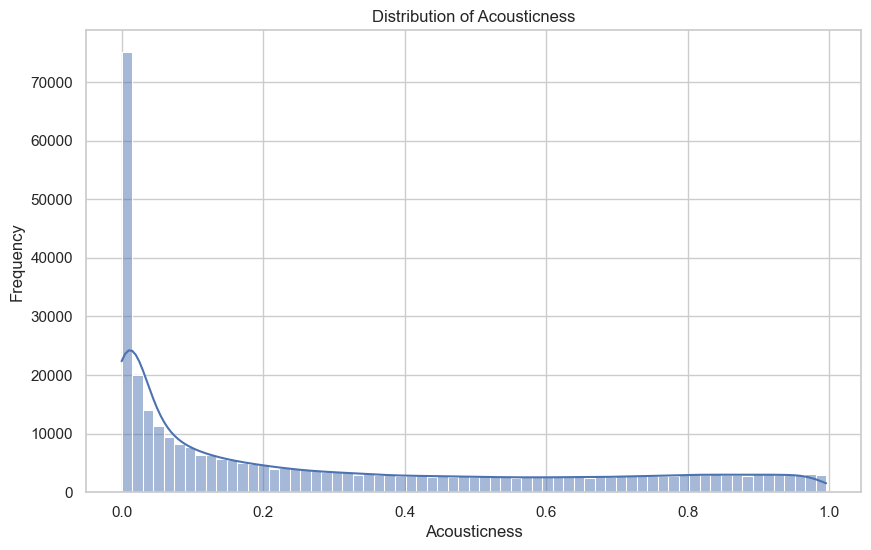

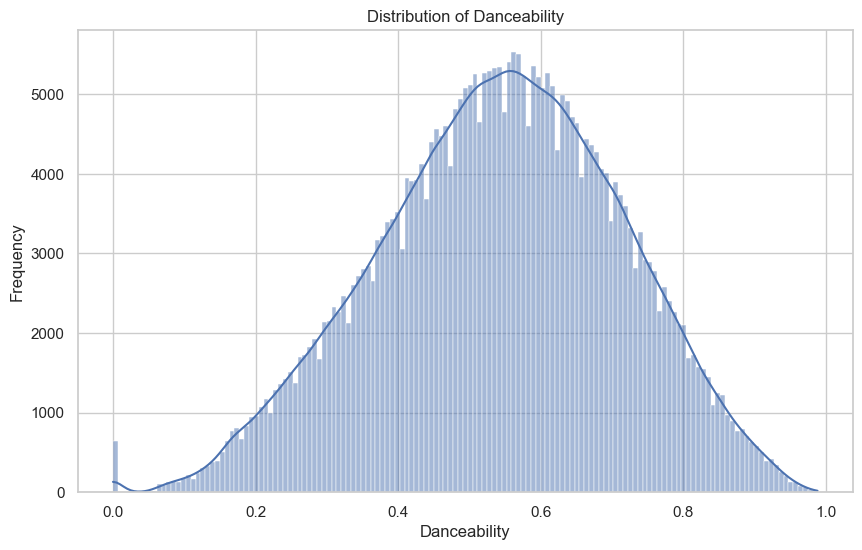

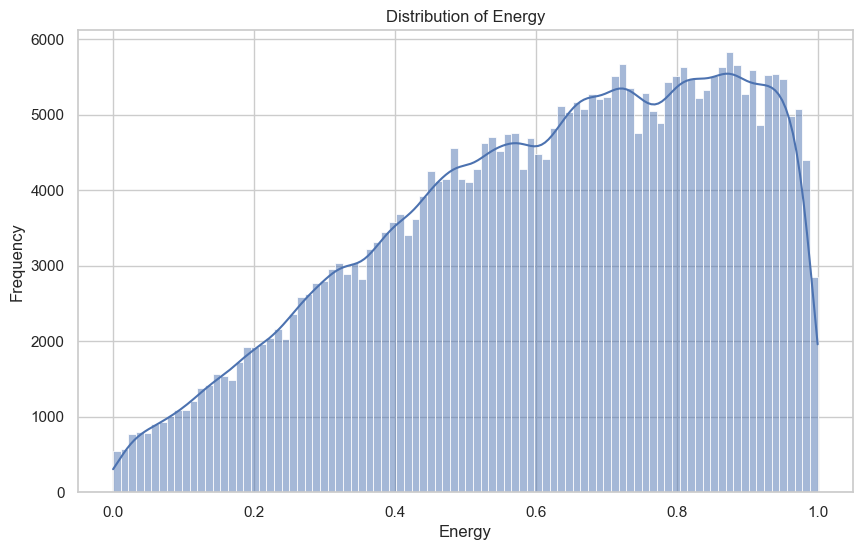

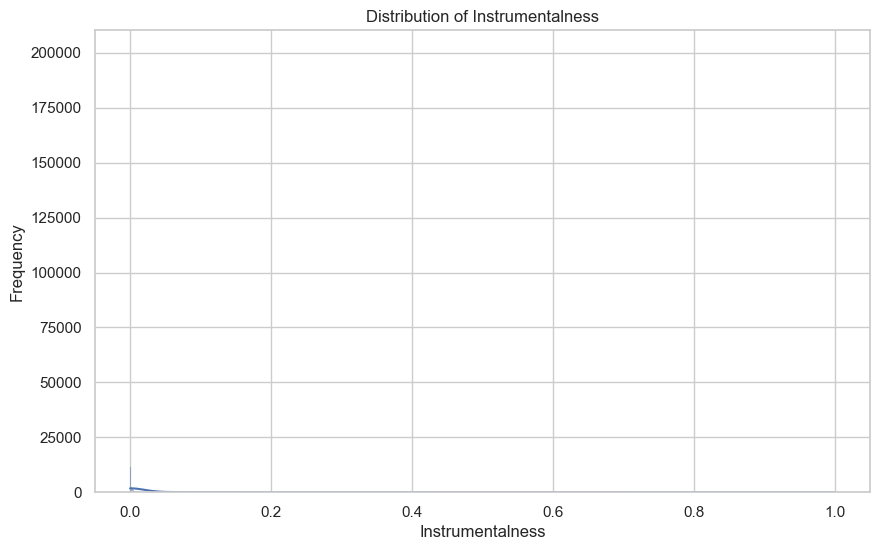

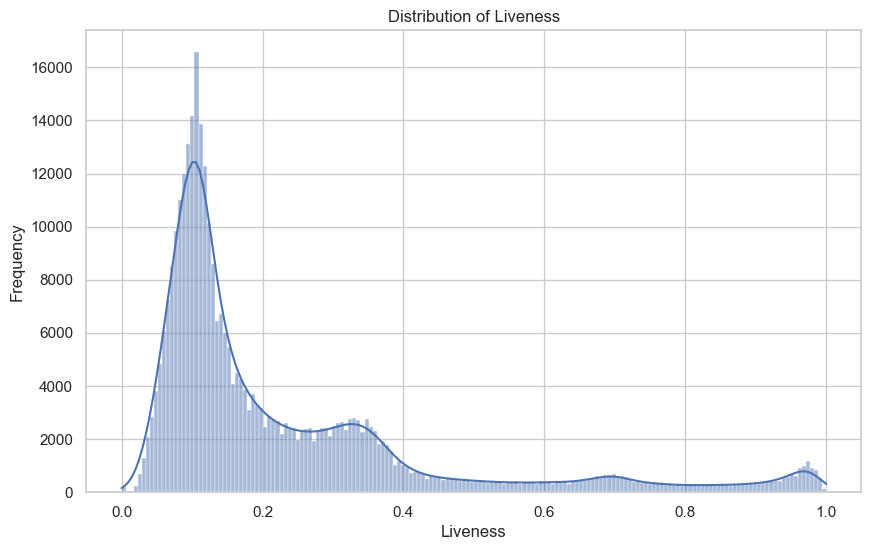

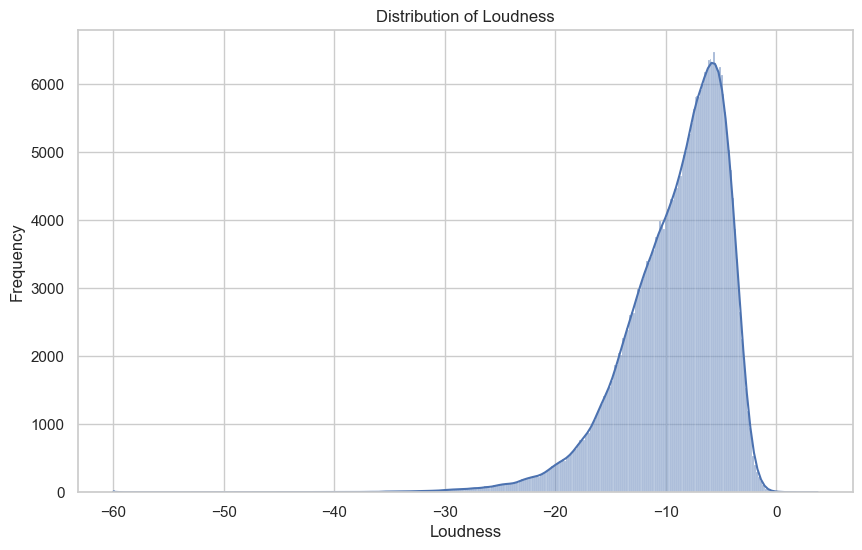

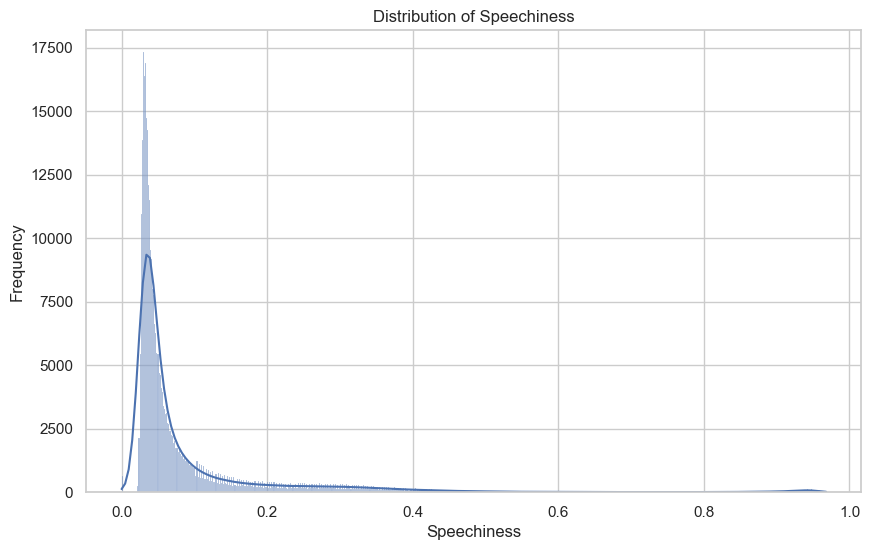

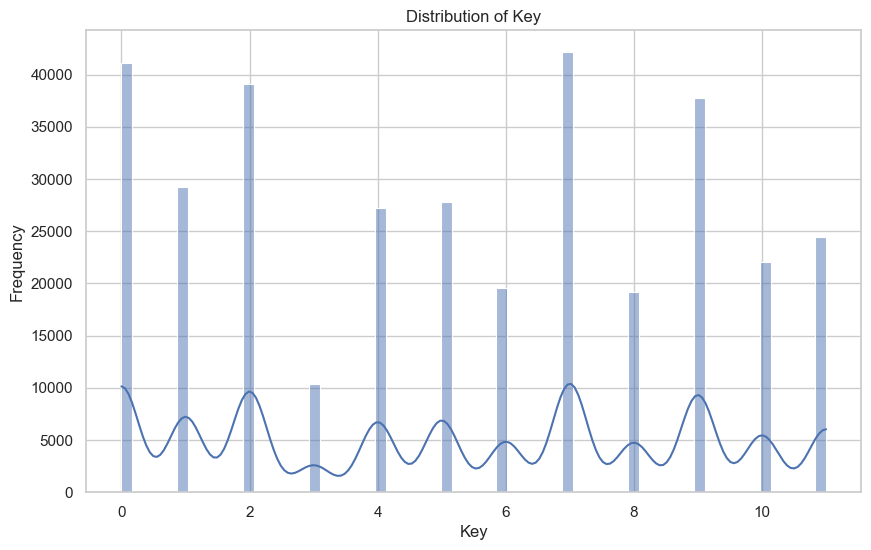

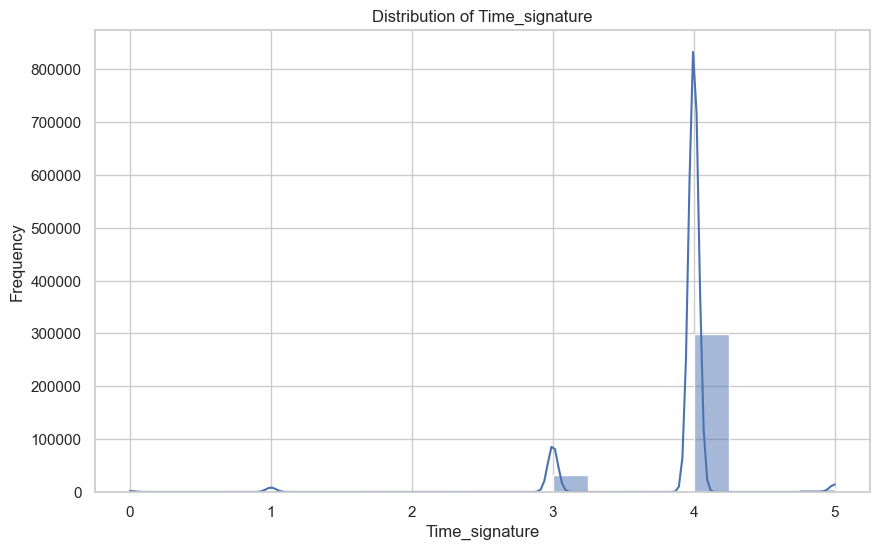

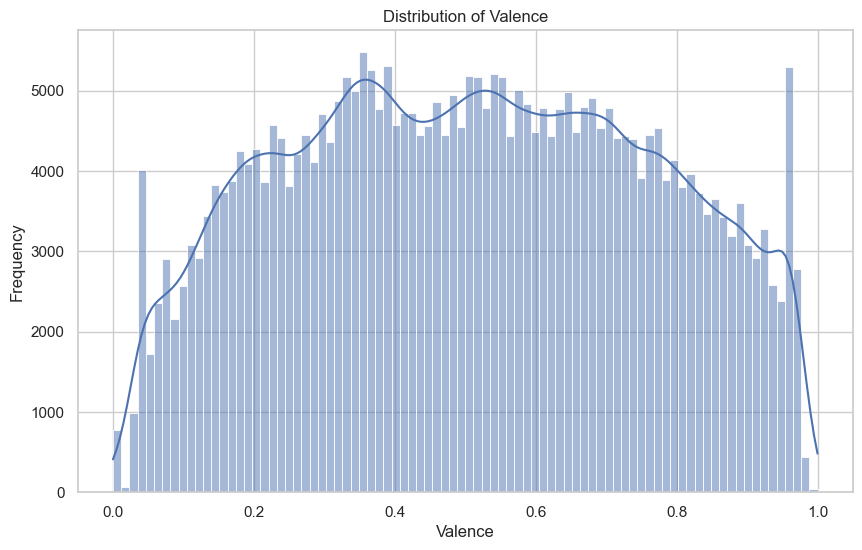

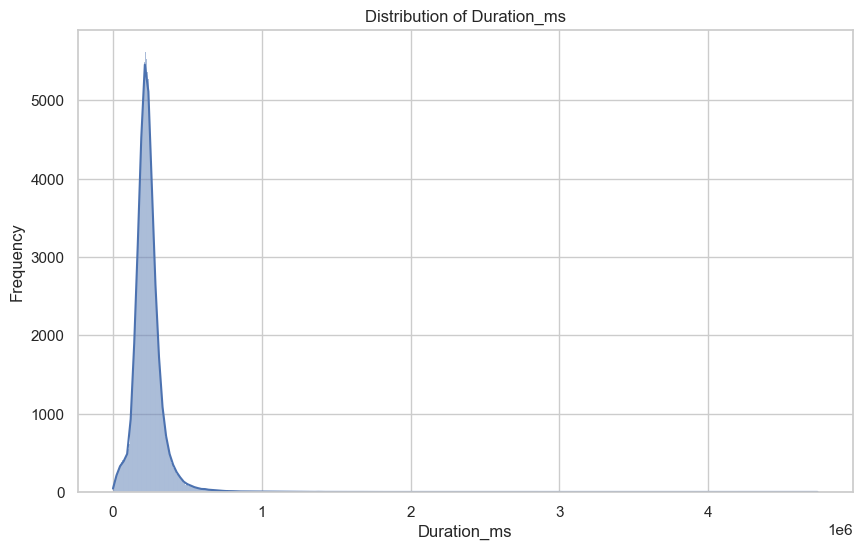

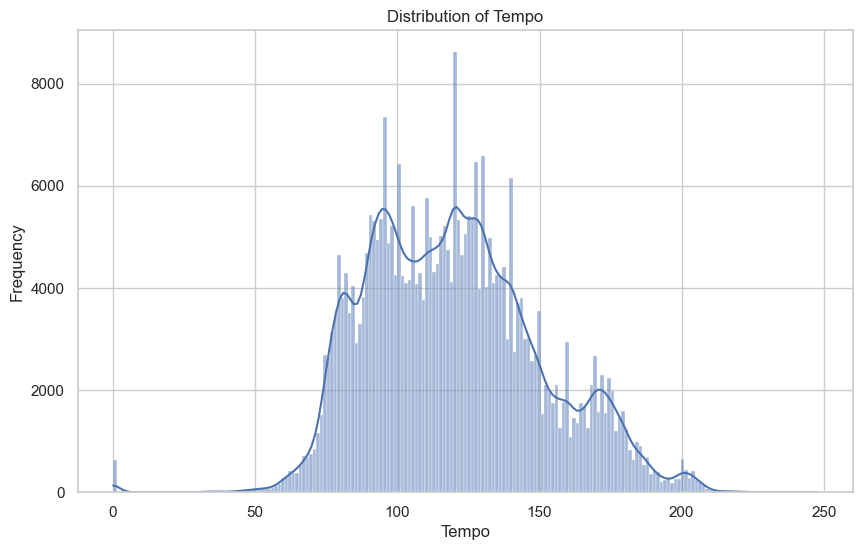

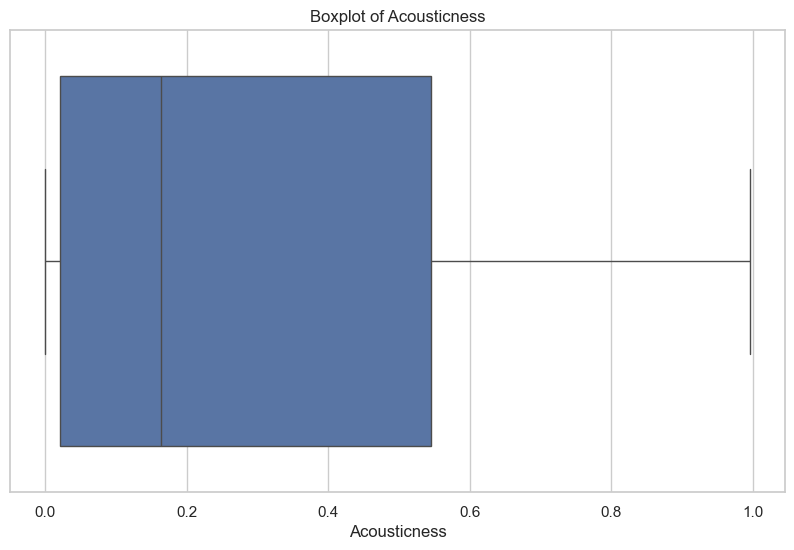

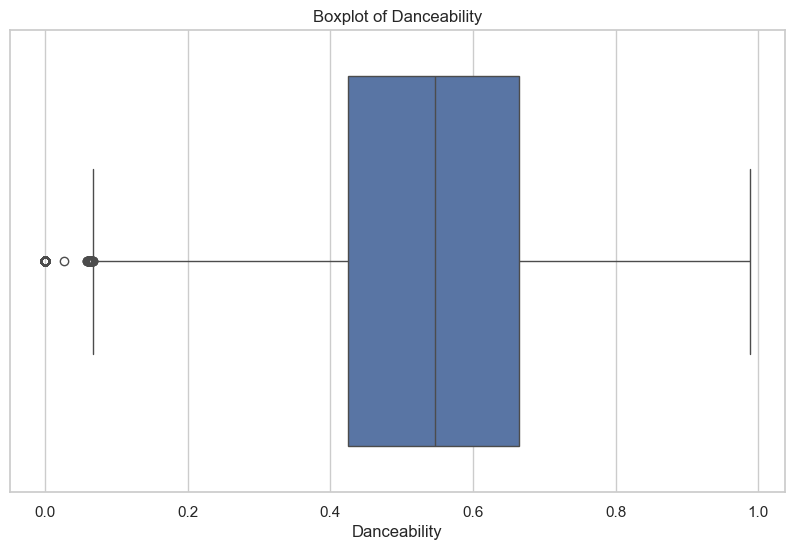

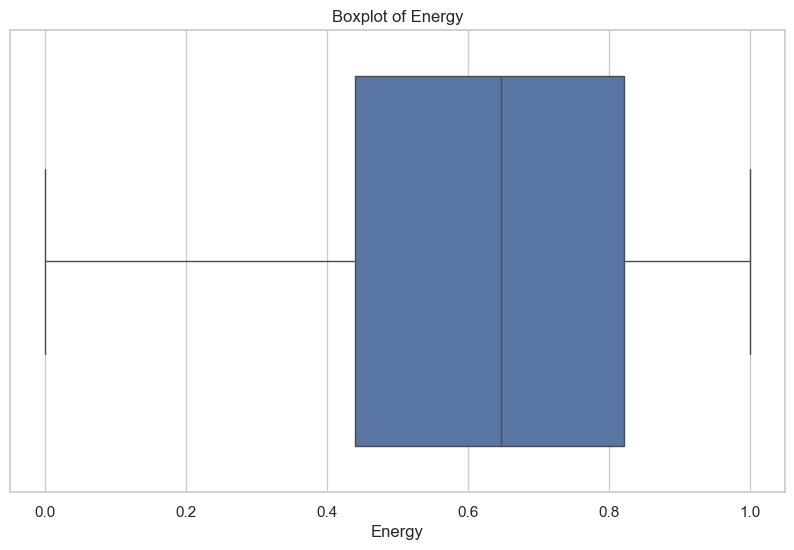

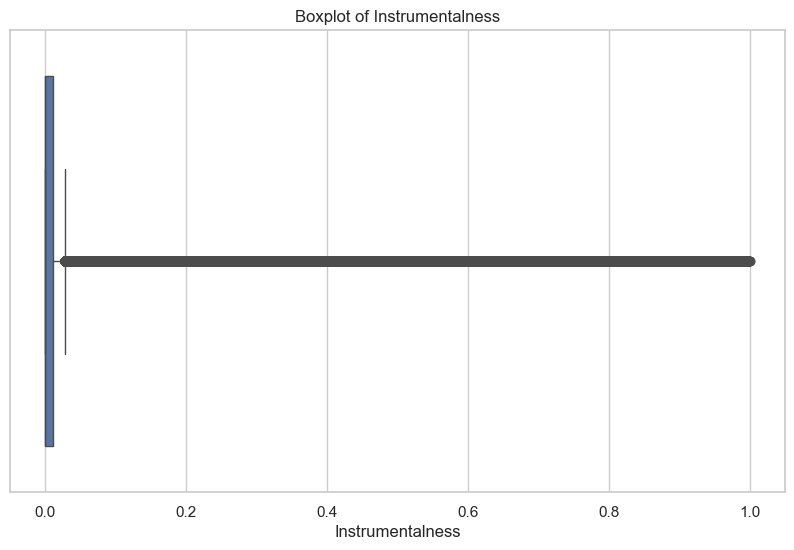

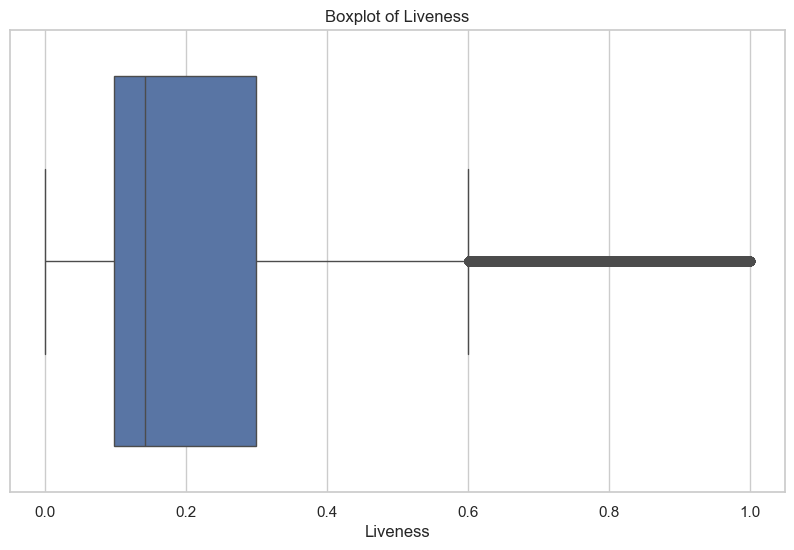

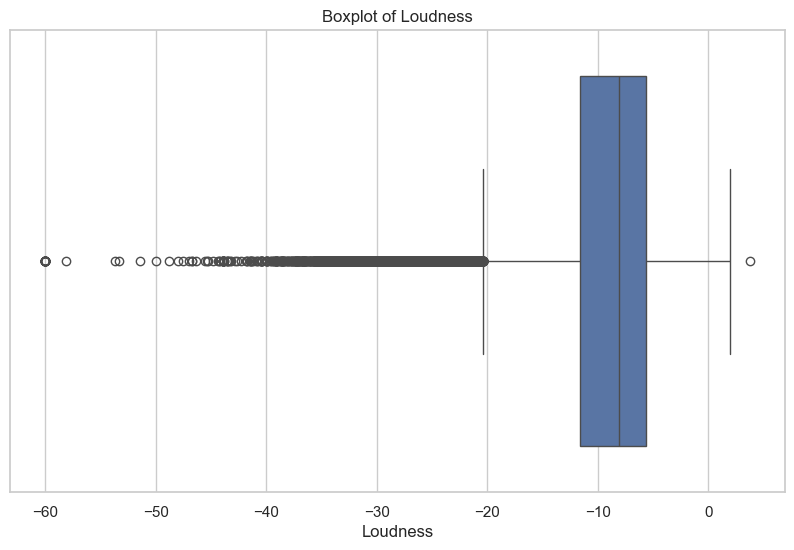

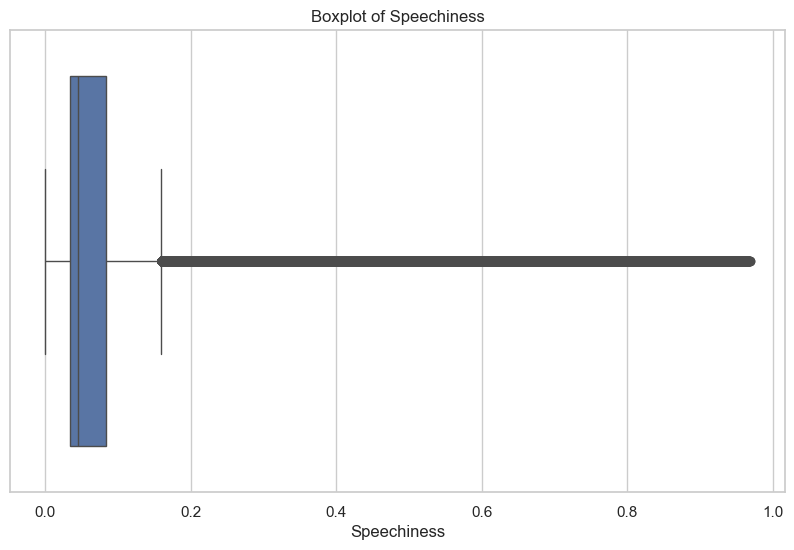

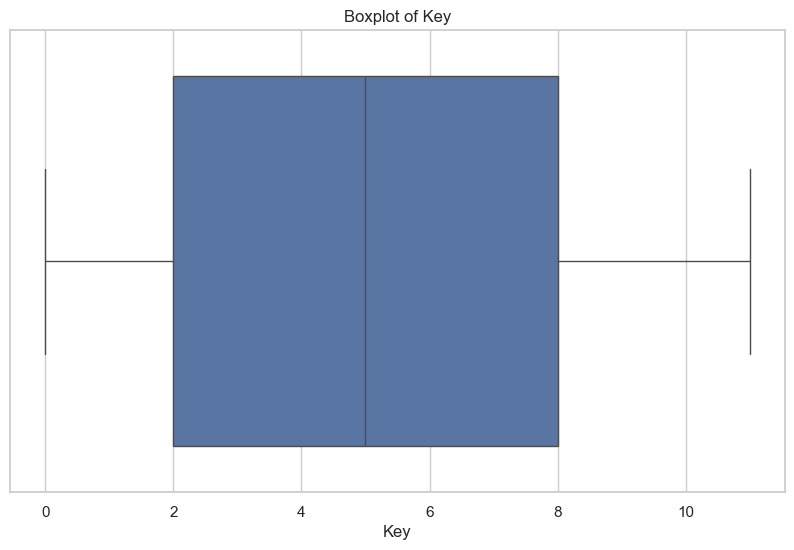

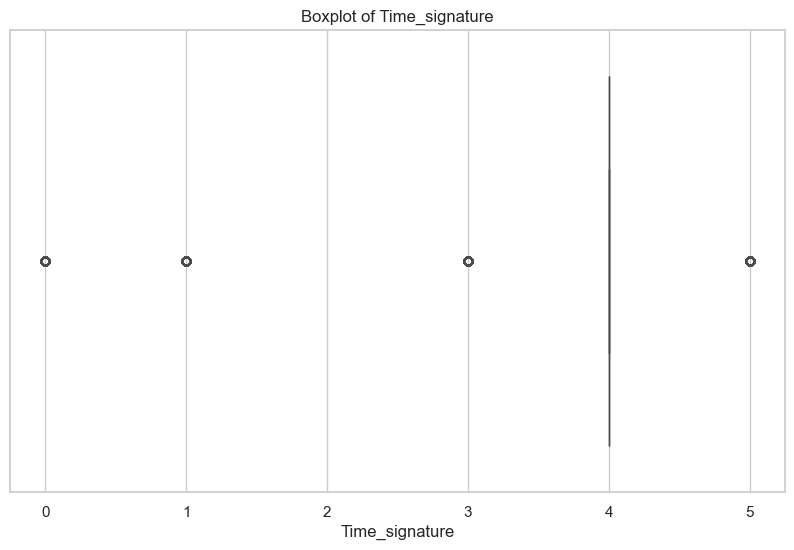

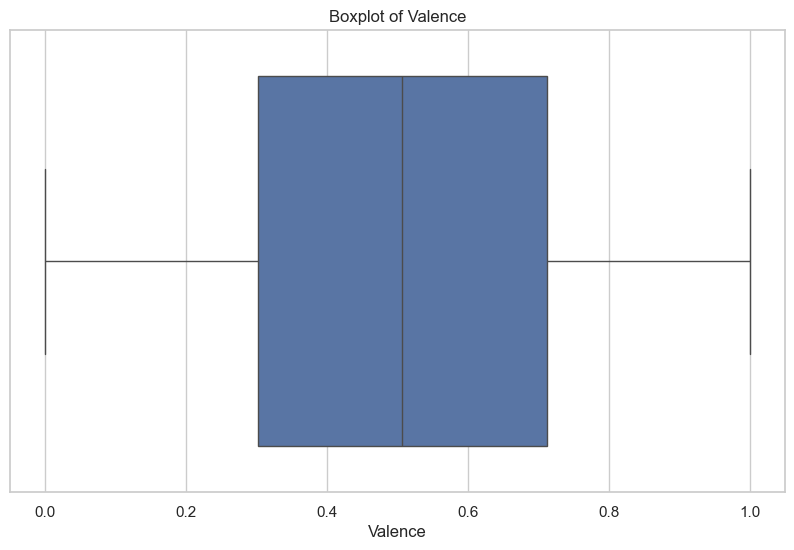

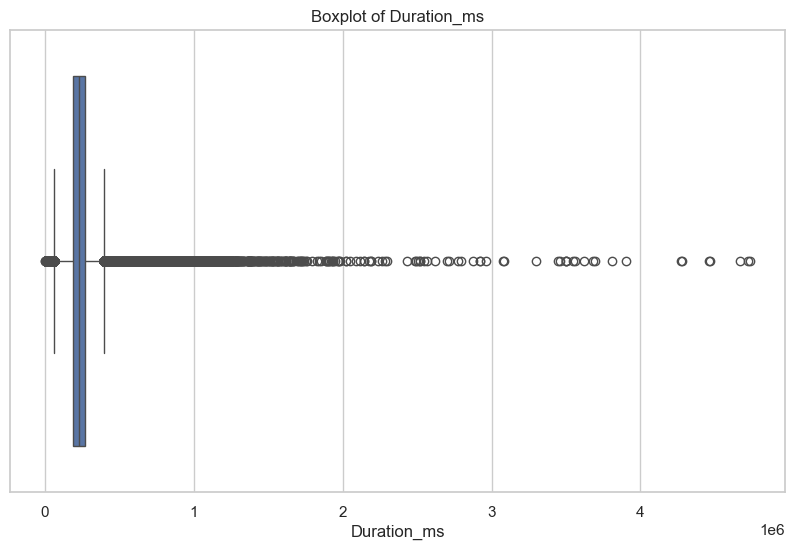

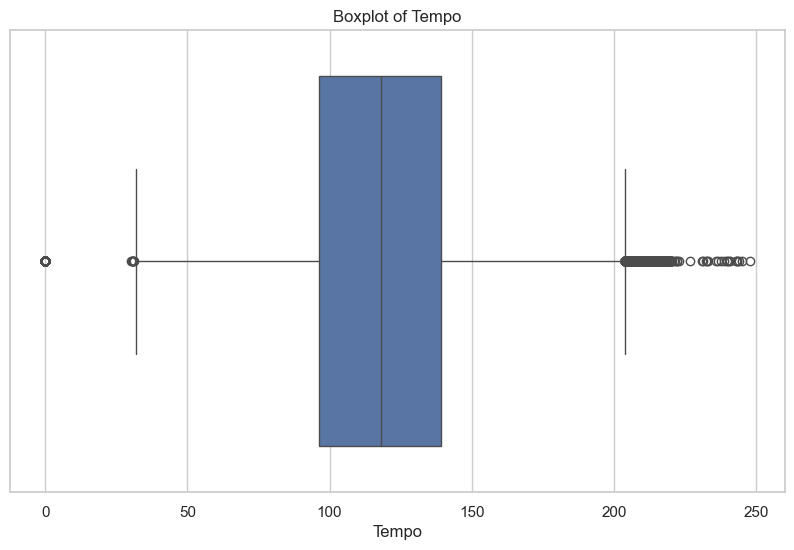

In [ ]:
# prompt: I want to see the distribution for all acoustic features

# Identify the acoustic features columns
acoustic_features = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'loudness',
    'speechiness',
    'key',
    'time_signature',
    'valence',
    'duration_ms',
    'tempo'
]


# Create histograms for each acoustic feature
for feature in acoustic_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(trial_df[feature], kde=True)
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.show()

# You could also use boxplots to visualize distribution and outliers
for feature in acoustic_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=trial_df[feature])
    plt.title(f'Boxplot of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.show()

In [ ]:
# column with frequency shows all uniique values in main genre column

genre_counts = trial_df['main_genre'].value_counts()
genre_counts


main_genre
rock                 67504
hip hop              35319
pop                  30085
indie                25959
country              25158
soul                 22589
singer-songwriter    16536
jazz                 12267
metal                10579
blues                 5886
new wave              5869
funk                  5045
latin                 4264
gospel                3666
edm                   3594
comedy                2964
classical             2876
experimental          2871
disco                 2149
world                 1861
new age               1678
soundtrack            1018
horrorcore             949
swing                  871
r&b                    245
freestyle              143
spoken word            118
adult standards        116
holiday                 90
trip hop                87
children                81
newgrass                63
grime                   56
exotica                 49
corrido                 44
big band                38
ragtime          

C:\Users\hp\AppData\Local\Temp\ipykernel_8176\3312656736.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




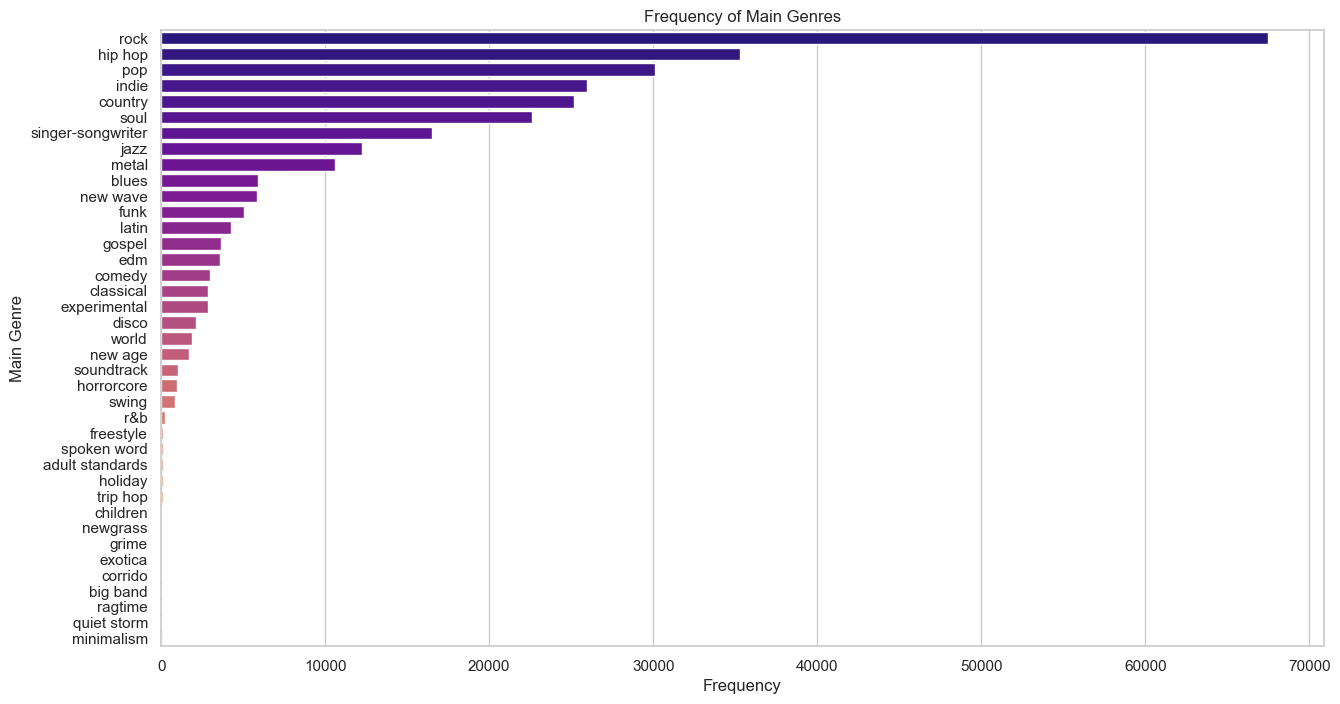

In [ ]:
# Plot unique main_genre in a frequency graph
plt.figure(figsize=(15, 8))
sns.countplot(data=trial_df, y='main_genre', order=trial_df['main_genre'].value_counts().index, palette='plasma')
plt.title('Frequency of Main Genres')
plt.xlabel('Frequency')
plt.ylabel('Main Genre')
plt.show()

In [ ]:
# Step 1: Drop duplicates so each album counts only once
album_level_df = trial_df[['album_id', 'main_genre']].dropna().drop_duplicates()

# Step 2: Count how many albums fall under each main genre
main_genre_album_counts = (
    album_level_df['main_genre']
    .value_counts()
    .sort_values(ascending=False)
    .reset_index()
)

main_genre_album_counts.columns = ['main_genre', 'album_count']


In [ ]:
from IPython.display import display
display(main_genre_album_counts)


main_genre  album_count
0                rock         5255
1                 pop         2433
2             hip hop         2351
3             country         2062
4                soul         1830
5               indie         1736
6   singer-songwriter         1290
7                jazz         1163
8               metal          844
9               blues          484
10               funk          474
11           new wave          449
12              latin          313
13                edm          291
14             gospel          270
15       experimental          246
16              disco          210
17             comedy          208
18          classical          206
19              world          178
20            new age          137
21         soundtrack          119
22              swing           71
23         horrorcore           58
24                r&b           19
25          freestyle           17
26    adult standards           11
27        spoken word            9
28            holiday            9
29              grime            8
30           trip hop            7
31           newgrass            6
32           children            5
33            corrido            4
34           big band            4
35            exotica            4
36            ragtime            3
37        quiet storm            2
38         minimalism            2

C:\Users\hp\AppData\Local\Temp\ipykernel_8176\1361354922.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




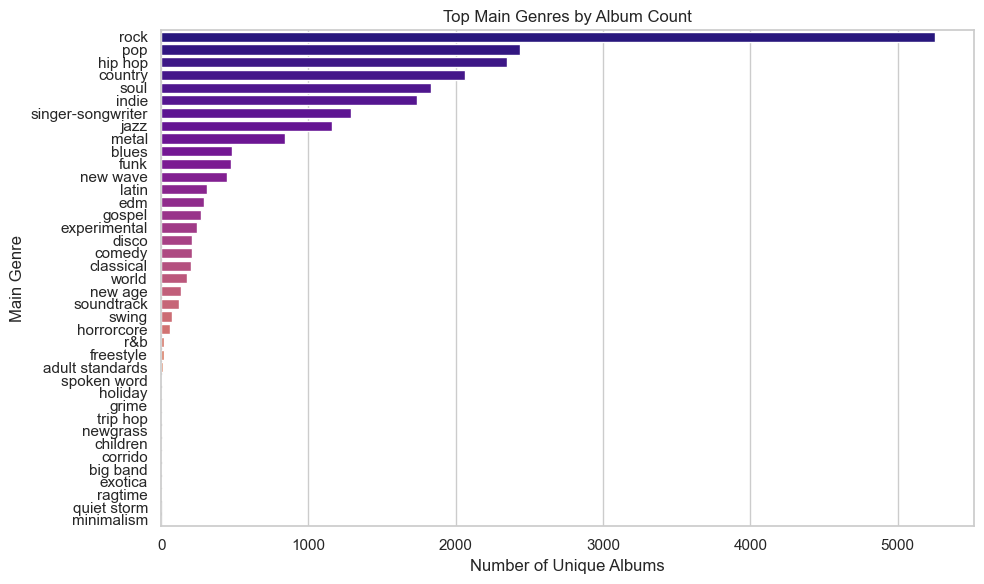

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=main_genre_album_counts.head(50), y='main_genre', x='album_count', palette='plasma')
plt.title('Top Main Genres by Album Count')
plt.xlabel('Number of Unique Albums')
plt.ylabel('Main Genre')
plt.tight_layout()
plt.show()


#Analytics for Dashboard

##Fequencies

In [ ]:
#show who are the most frequent artist in the data set, frequent albums?, any frequent genres than most? and also the rarest ones.
artist_counts = trial_df['artist_name'].value_counts()
print(artist_counts)

artist_name
Various Artists                     11578
Soundtrack                           8260
Original Cast                         888
Original Broadway Cast Recording      855
Elvis Presley                         772
                                    ...  
Steam                                   1
DJ Poet Name Life                       1
Trae Tha Truth                          1
Van Morrison & Linda Gail Lewis         1
New York City                           1
Name: count, Length: 8081, dtype: int64


In [ ]:
# Step 1: Get unique artist-album pairs
artist_album_df = trial_df[['artist_name', 'album_id']].dropna().drop_duplicates()

# Step 2: Count how many unique albums each artist has
artist_album_counts = (
    artist_album_df
    .groupby('artist_name')['album_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'album_id': 'album_count'})
)
# Step 3: Exclude top 3 most frequent artists
top3_artists = artist_album_counts.head(3)['artist_name'].tolist()

filtered_artist_album_counts = artist_album_counts[
    ~artist_album_counts['artist_name'].isin(top3_artists)
]


C:\Users\hp\AppData\Local\Temp\ipykernel_8176\979303143.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




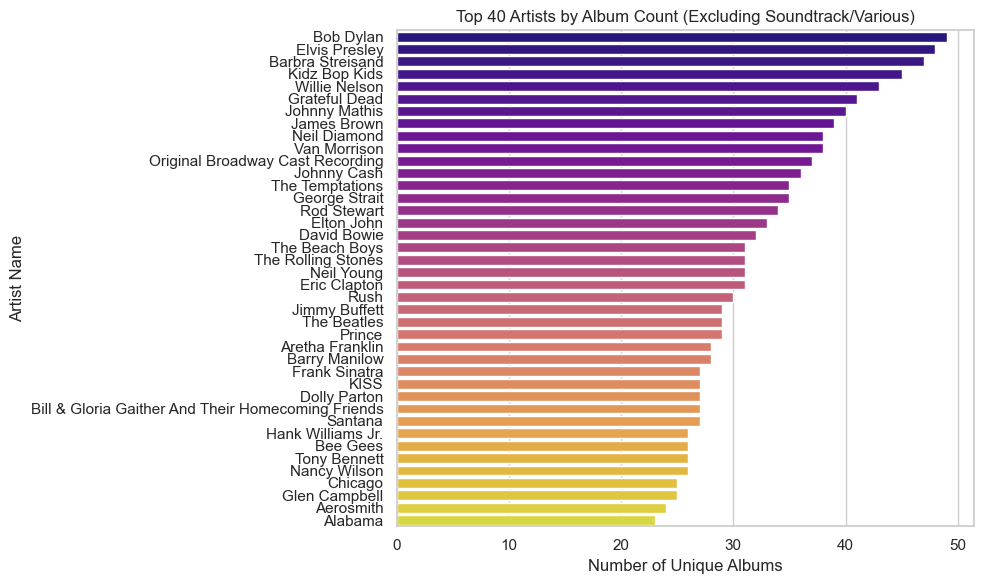

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_artist_album_counts.head(40), x='album_count', y='artist_name', palette='plasma')
plt.title("Top 40 Artists by Album Count (Excluding Soundtrack/Various)")
plt.xlabel("Number of Unique Albums")
plt.ylabel("Artist Name")
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Drop duplicates at the album level
df_album_level = trial_df[['main_genre', 'artist_name', 'album_id']].dropna().drop_duplicates()

# Step 2: Group by main_genre and artist_name, count unique albums
artist_genre_album_counts = (
    df_album_level
    .groupby(['main_genre', 'artist_name'])['album_id']
    .nunique()
    .reset_index()
    .rename(columns={'album_id': 'album_count'})
)


In [ ]:
top_n = 3

top_artists_per_genre = (
    artist_genre_album_counts
    .sort_values(['main_genre', 'album_count'], ascending=[True, False])
    .groupby('main_genre')
    .head(top_n)
)

display(top_artists_per_genre)


main_genre                                        artist_name  \
1     adult standards                                      Robert Goulet   
0     adult standards                                         Patty Duke   
2     adult standards                                         Sing-Along   
4            big band                    Enoch Light & The Light Brigade   
3            big band  Elvis Presley With The Royal Philharmonic Orch...   
...               ...                                                ...   
7759         trip hop                                             Tricky   
7758         trip hop                                         Portishead   
7788            world                                 El Trono de Mexico   
7808            world                                     Less Than Jake   
7845            world                                 The Avett Brothers   

      album_count  
1               9  
0               1  
2               1  
4               2  
3               1  
...           ...  
7759            5  
7758            2  
7788            7  
7808            7  
7845            7  

[112 rows x 3 columns]

In [ ]:
# Step 1: Drop duplicates to get unique artist–album pairs
artist_album_df = trial_df[['artist_name', 'album_id']].dropna().drop_duplicates()

# Step 2: Count number of unique albums per artist
artist_album_counts = (
    artist_album_df
    .groupby('artist_name')['album_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'album_name': 'album_count'})
)
artist_album_counts.head(10)


artist_name  album_id
0   Various Artists       577
1        Soundtrack       513
2     Original Cast        51
3         Bob Dylan        49
4     Elvis Presley        48
5  Barbra Streisand        47
6     Kidz Bop Kids        45
7     Willie Nelson        43
8     Grateful Dead        41
9     Johnny Mathis        40

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: De-duplicate at album level
df_album_level = trial_df[['main_genre', 'artist_name', 'album_id']].dropna().drop_duplicates()

# Step 1.5: Exclude generic artists
excluded_artists = ['Soundtrack', 'Various Artists', 'Original Cast']
df_album_level = df_album_level[~df_album_level['artist_name'].isin(excluded_artists)]

# Step 2: Count albums per artist per genre
artist_genre_album_counts = (
    df_album_level
    .groupby(['main_genre', 'artist_name'])['album_id']
    .nunique()
    .reset_index(name='album_count')
)

# Step 3: Get top 10 genres by total album count
top_genres = (
    artist_genre_album_counts
    .groupby('main_genre')['album_count']
    .sum()
    .nlargest(10)
    .index
)

# Step 4: Get top 3 artists per top genre only
filtered = artist_genre_album_counts[artist_genre_album_counts['main_genre'].isin(top_genres)]
top_artists_per_genre = (
    filtered
    .sort_values(['main_genre', 'album_count'], ascending=[True, False])
    .groupby('main_genre')
    .head(3)
)


C:\Users\hp\AppData\Local\Temp\ipykernel_8176\545939236.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\hp\AppData\Local\Temp\ipykernel_8176\545939236.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\hp\AppData\Local\Temp\ipykernel_8176\545939236.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\hp\AppData\Local\Temp\ipykernel_8176\545939236.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\hp\AppData\Local\Temp\ipykernel_8176\545939236.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

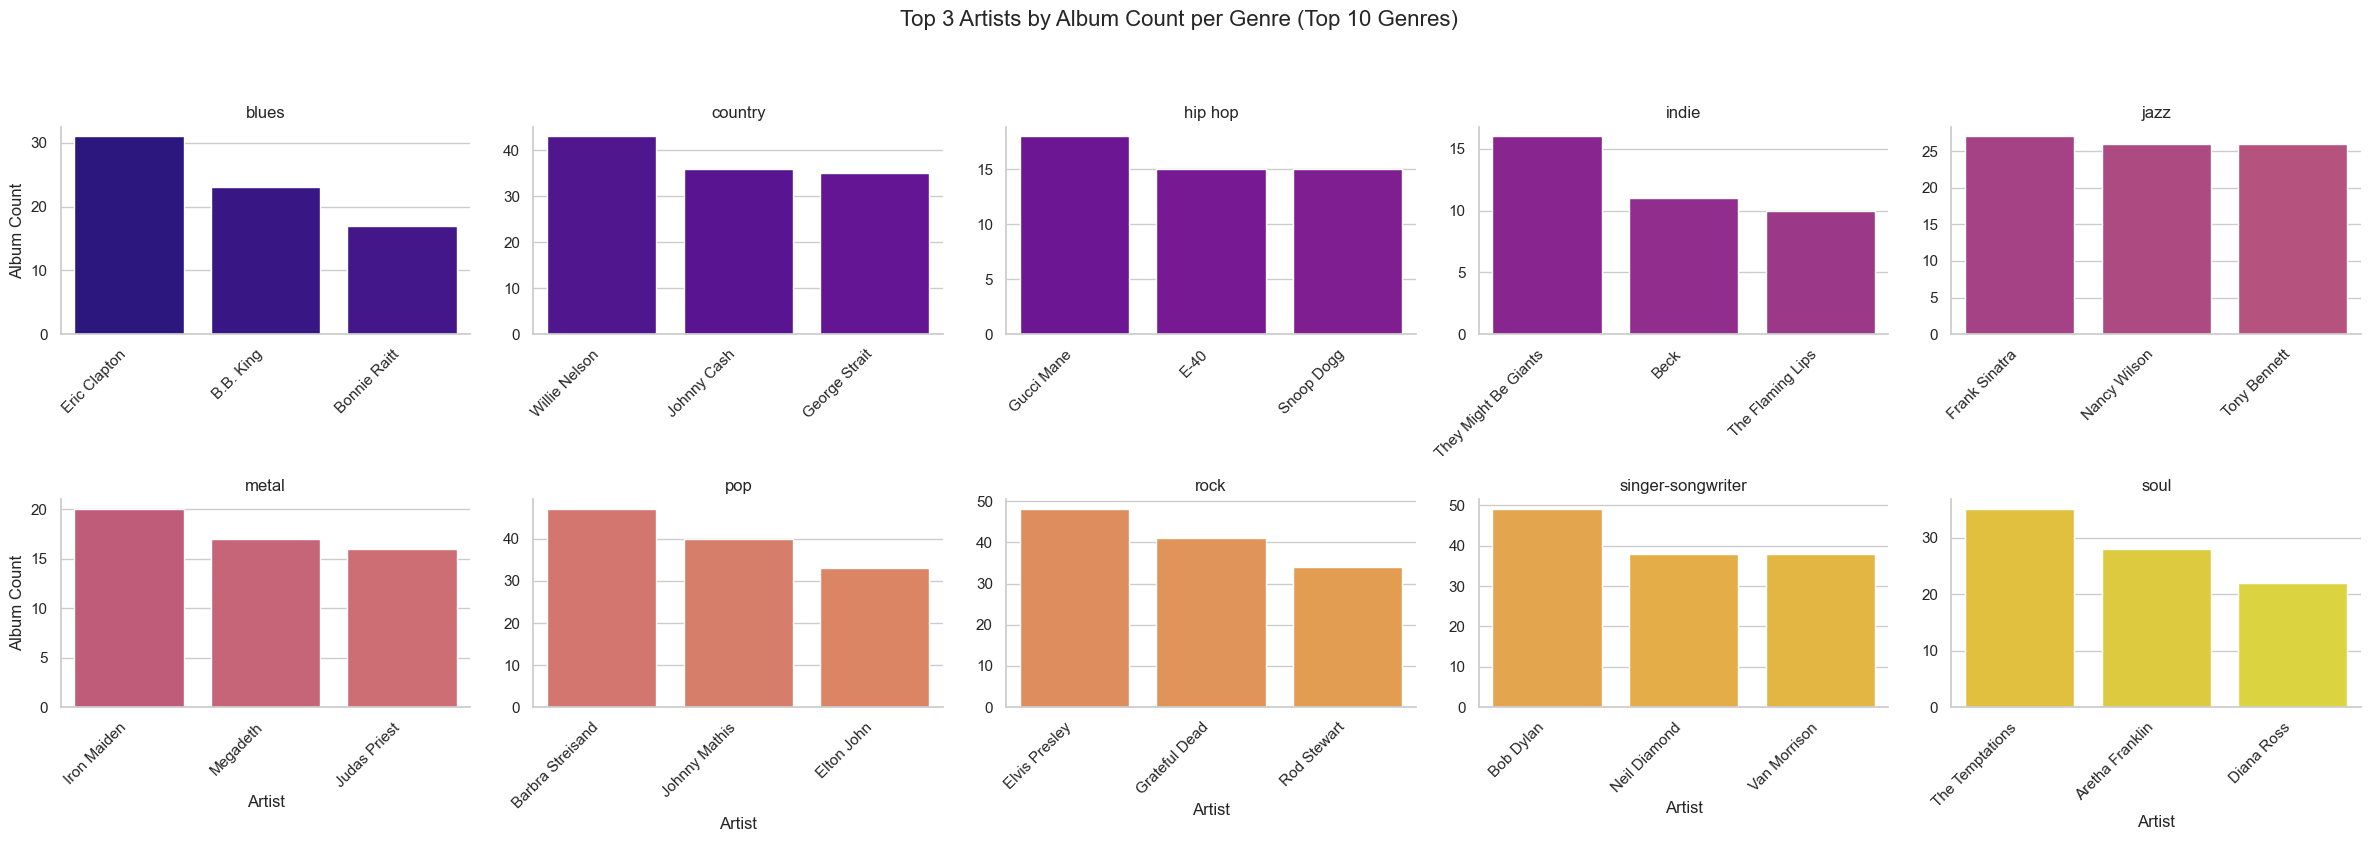

In [ ]:
# Seaborn horizontal bar chart per genre (faceted)
sns.set(style="whitegrid")

g = sns.catplot(
    data=top_artists_per_genre,
    y='album_count',
    x='artist_name',
    col='main_genre',
    kind='bar',
    col_wrap=5,
    height=4,
    aspect=1.2,
    palette='plasma',
    sharex=False,
    sharey=False
)

# Flip axes for horizontal bars
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Artist", "Album Count")
g.fig.suptitle("Top 3 Artists by Album Count per Genre (Top 10 Genres)", y=1.05, fontsize=16)

plt.tight_layout()
plt.show()


## Heatmaps: Acoustics

In [ ]:
selected_features = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'speechiness',
    'valence', 'tempo'
]


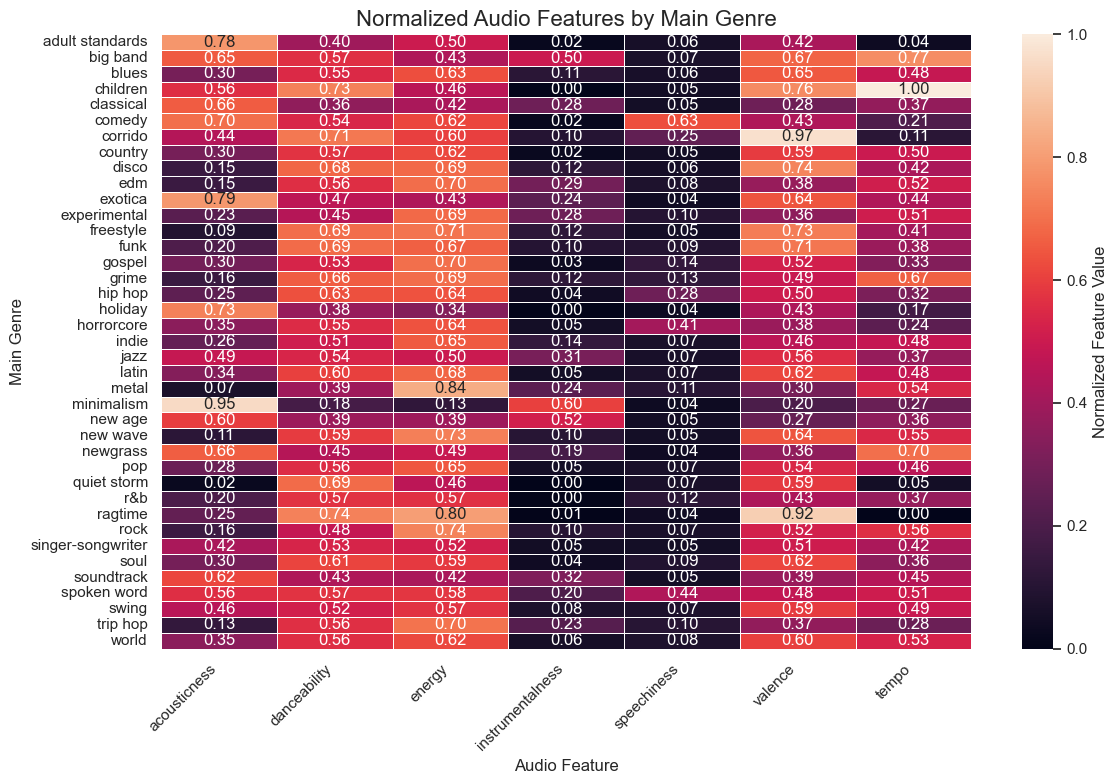

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define the selected features (make sure these are in your data)
selected_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'speechiness', 'valence', 'tempo'
]

# Step 1: Prepare the album-level dataset
audio_cols = selected_features + ['main_genre', 'album_id']
audio_df = trial_df[audio_cols].dropna().drop_duplicates(subset=['album_id'])

# Step 2: Compute average audio features per main genre
genre_audio_avg = audio_df.groupby('main_genre')[selected_features].mean()

# Step 3: Normalize only 'tempo' to 0–1 scale
scaler = MinMaxScaler()
genre_audio_avg['tempo'] = scaler.fit_transform(genre_audio_avg[['tempo']])

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    genre_audio_avg,
    cmap='rocket',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalized Feature Value'}
)

plt.title('Normalized Audio Features by Main Genre', fontsize=16)
plt.xlabel('Audio Feature')
plt.ylabel('Main Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# 🎯 Define your features
selected_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'speechiness', 'valence', 'tempo'
]

# 📦 Step 1: Prepare album-level data
audio_cols = selected_features + ['main_genre', 'album_id']
audio_df = trial_df[audio_cols].dropna().drop_duplicates(subset=['album_id'])

# 📊 Step 2: Group by main genre and calculate average features
genre_audio_avg = audio_df.groupby('main_genre')[selected_features].mean()

# 🔧 Step 3: Normalize only 'tempo'
scaler = MinMaxScaler()
genre_audio_avg['tempo'] = scaler.fit_transform(genre_audio_avg[['tempo']])

# 🧱 Step 4: Reshape to long format for Plotly
genre_audio_long = genre_audio_avg.reset_index().melt(
    id_vars='main_genre',
    var_name='feature',
    value_name='value'
)

# 🖼️ Step 5: Create interactive heatmap
fig = px.imshow(
    genre_audio_avg.values,
    labels=dict(x="Feature", y="Main Genre", color="Value"),
    x=genre_audio_avg.columns,
    y=genre_audio_avg.index,
    text_auto=".2f",
    color_continuous_scale='Tealrose',
    aspect='auto',
    title='Interactive Heatmap: Normalized Audio Features by Main Genre'
)

fig.update_layout(
    xaxis_title="Audio Feature",
    yaxis_title="Main Genre",
    font=dict(size=12),
    height=600
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

##Radar charts

In [ ]:
# Define your audio feature columns
audio_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence', 'tempo']

# Compute average features per subgenre (no album_id filtering)
subgenre_profile = (
    trial_df[['subgenre'] + audio_cols]
    .dropna()
    .groupby('subgenre')
    .mean()
)


In [ ]:
subgenre_profile.loc['trap']


acousticness          0.166866
danceability          0.749750
energy                0.591402
instrumentalness      0.032204
speechiness           0.206260
valence               0.389364
tempo               131.872016
Name: trap, dtype: float64

In [ ]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence', 'tempo']

#normlaize tempo
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
subgenre_profile[features] = scaler.fit_transform(subgenre_profile[features])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sub = 'trap'  # change to any subgenre you want to visualize

# Get values
values = subgenre_profile.loc[sub, features].values

# Close the radar chart loop
values = np.append(values, values[0])
labels = features + [features[0]]

# Calculate angles
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close loop


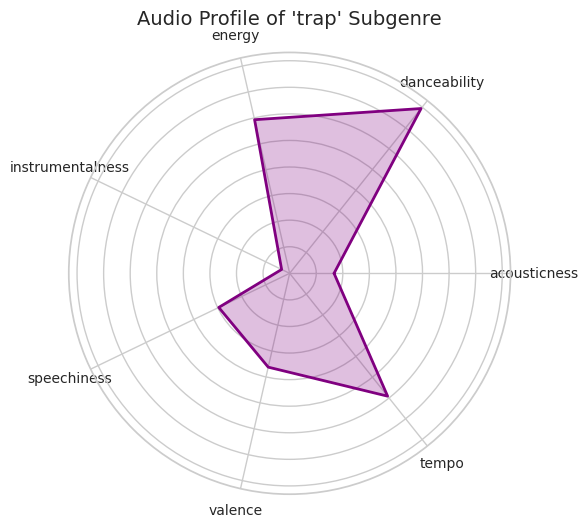

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the subgenre and features
sub = 'trap'  # or any subgenre in your dataset
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence', 'tempo']

# Get values and close the loop
values = subgenre_profile.loc[sub, features].values
values = np.append(values, values[0])  # repeat the first value at the end to close the loop

# Calculate angles
num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, values, color='purple', linewidth=2)
ax.fill(angles, values, color='purple', alpha=0.25)

# Set the feature labels (only the original ones)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=10)

ax.set_yticklabels([])  # Hide radial labels
ax.set_title(f"Audio Profile of '{sub}' Subgenre", fontsize=14, pad=20)

plt.tight_layout()
plt.show()


In [ ]:
# Define the audio features
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence']

# Compute average audio features per main genre
genre_profile = (
    trial_df[['main_genre'] + features]
    .dropna()
    .groupby('main_genre')
    .mean()
)

# Get the top 5 most frequent genres
top_genres = (
    trial_df['main_genre']
    .value_counts()
    .head(10)
    .index
)

genre_profile = genre_profile.loc[top_genres]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Close the radar loop
values_dict = {}
for genre in top_genres:
    values = genre_profile.loc[genre, features].values
    values_dict[genre] = np.append(values, values[0])  # loop closed

# Radar chart angle setup
num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]


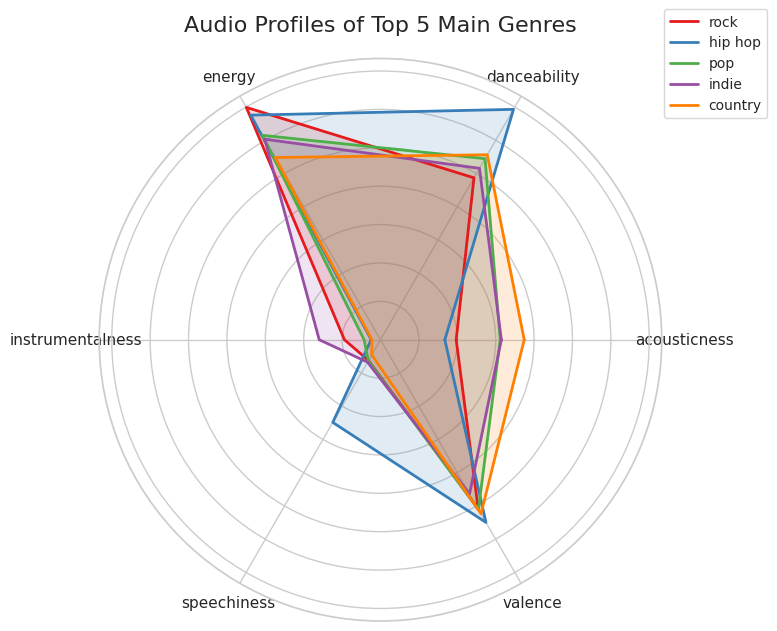

In [ ]:
# Plot setup
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

for genre, color in zip(top_genres, colors):
    ax.plot(angles, values_dict[genre], label=genre, color=color, linewidth=2)
    ax.fill(angles, values_dict[genre], color=color, alpha=0.15)

# Add feature labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=11)

# Hide y-ticks and add title
ax.set_yticklabels([])
ax.set_title("Audio Profiles of Top 5 Main Genres", fontsize=16, pad=20)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
main_genre = 'rock'  # Change this to any genre in your data

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness', 'valence']
# Step 1: Filter data for that main genre
genre_df = trial_df[trial_df['main_genre'] == main_genre].dropna(subset=features + ['subgenre'])

# Step 2: Get top 5 subgenres by album count
top_subgenres = (
    genre_df[['album_id', 'subgenre']].drop_duplicates()
    .subgenre.value_counts()
    .head(5)
    .index
)

# Step 3: Compute mean audio features for main genre and each subgenre
mean_profiles = {}

# Main genre profile
mean_profiles[main_genre] = genre_df[features].mean().values

# Subgenre profiles
for sub in top_subgenres:
    sub_df = genre_df[genre_df['subgenre'] == sub]
    mean_profiles[sub] = sub_df[features].mean().values



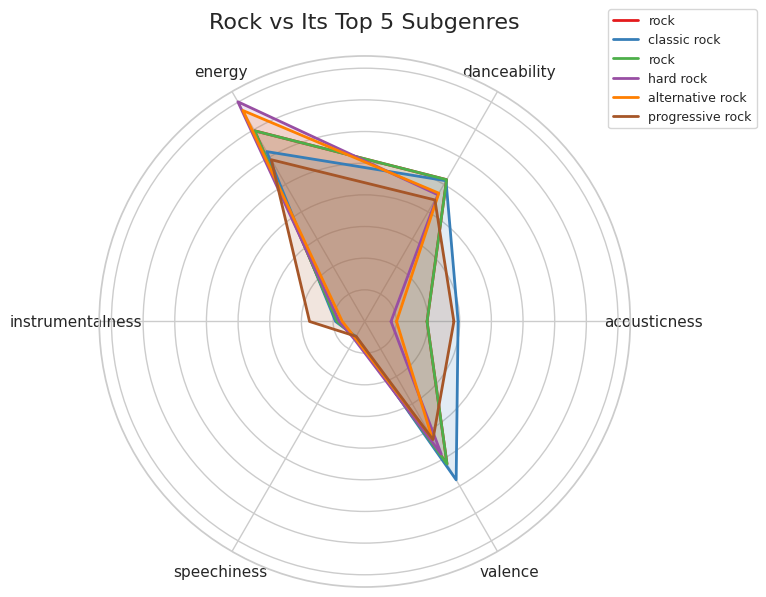

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Close the loop
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

# Close value loop too
for label in mean_profiles:
    mean_profiles[label] = np.append(mean_profiles[label], mean_profiles[label][0])
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']
labels = [main_genre] + list(top_subgenres)

for label, color in zip(labels, colors):
    ax.plot(angles, mean_profiles[label], label=label, color=color, linewidth=2)
    ax.fill(angles, mean_profiles[label], color=color, alpha=0.15)

# Aesthetic settings
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=11)
ax.set_yticklabels([])
ax.set_title(f"{main_genre.title()} vs Its Top 5 Subgenres", fontsize=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1), fontsize=9)

plt.tight_layout()
plt.show()


<Axes: title={'center': 'How Rock Changed Over Time'}, xlabel='decade'>

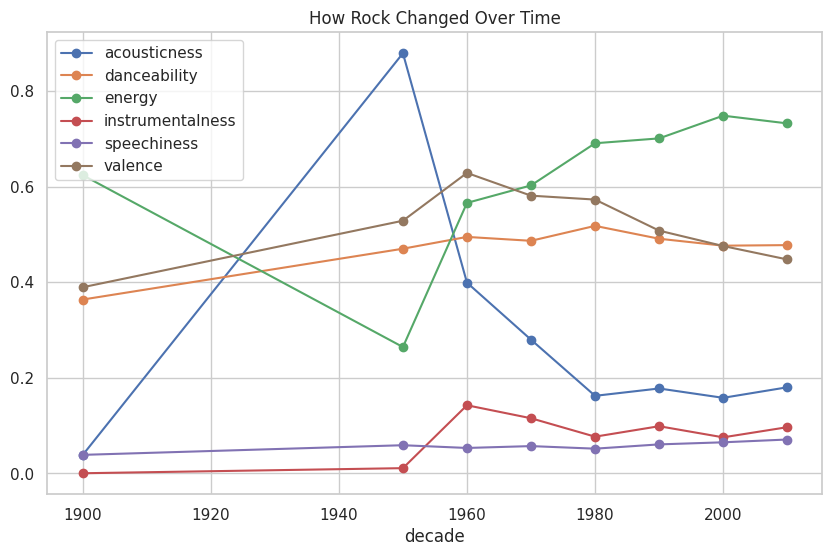

In [ ]:
# Group by decade
rock_timeline = (
    trial_df[trial_df['main_genre'] == 'rock']
    .dropna(subset=features + ['decade'])
    .groupby('decade')[features].mean()
)

rock_timeline.plot(marker='o', figsize=(10, 6), title="How Rock Changed Over Time")


In [ ]:
# Step 1: Filter to rock albums only
rock_df = trial_df[trial_df['main_genre'] == 'rock']

# Step 2: Drop duplicates at album level
rock_album_df = rock_df[['artist_name', 'decade', 'album_id']].dropna().drop_duplicates()

# Step 3: Count unique albums per artist per decade
rock_artist_decade_counts = (
    rock_album_df
    .groupby(['decade', 'artist_name'])['album_id']
    .nunique()
    .reset_index(name='album_count')
)

# Step 4: Get top 3 artists per decade
top_artists_per_decade = (
    rock_artist_decade_counts
    .sort_values(['decade', 'album_count'], ascending=[True, False])
    .groupby('decade')
    .head(3)
)

top_artists_per_decade.head(20)


decade         artist_name  album_count
0       1900         Royal Bliss            1
1       1950       Elvis Presley            2
27      1960       Elvis Presley           18
104     1960        The Ventures           18
40      1960     Jerry Lee Lewis            9
199     1970       Elvis Presley           14
166     1970             Chicago           12
381     1970       The Guess Who           11
681     1980                Rush            9
634     1980         Pat Benatar            8
591     1980                KISS            7
1052    1990               Phish           12
1046    1990           Pearl Jam            7
880     1990  Dave Matthews Band            6
1351    2000  Dave Matthews Band           11
1439    2000       Grateful Dead           10
1633    2000           Relient K            8
2113    2010       Grateful Dead           11
2045    2010       Elvis Presley            9
1918    2010        Bethel Music            8

/tmp/ipython-input-69-2310250926.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




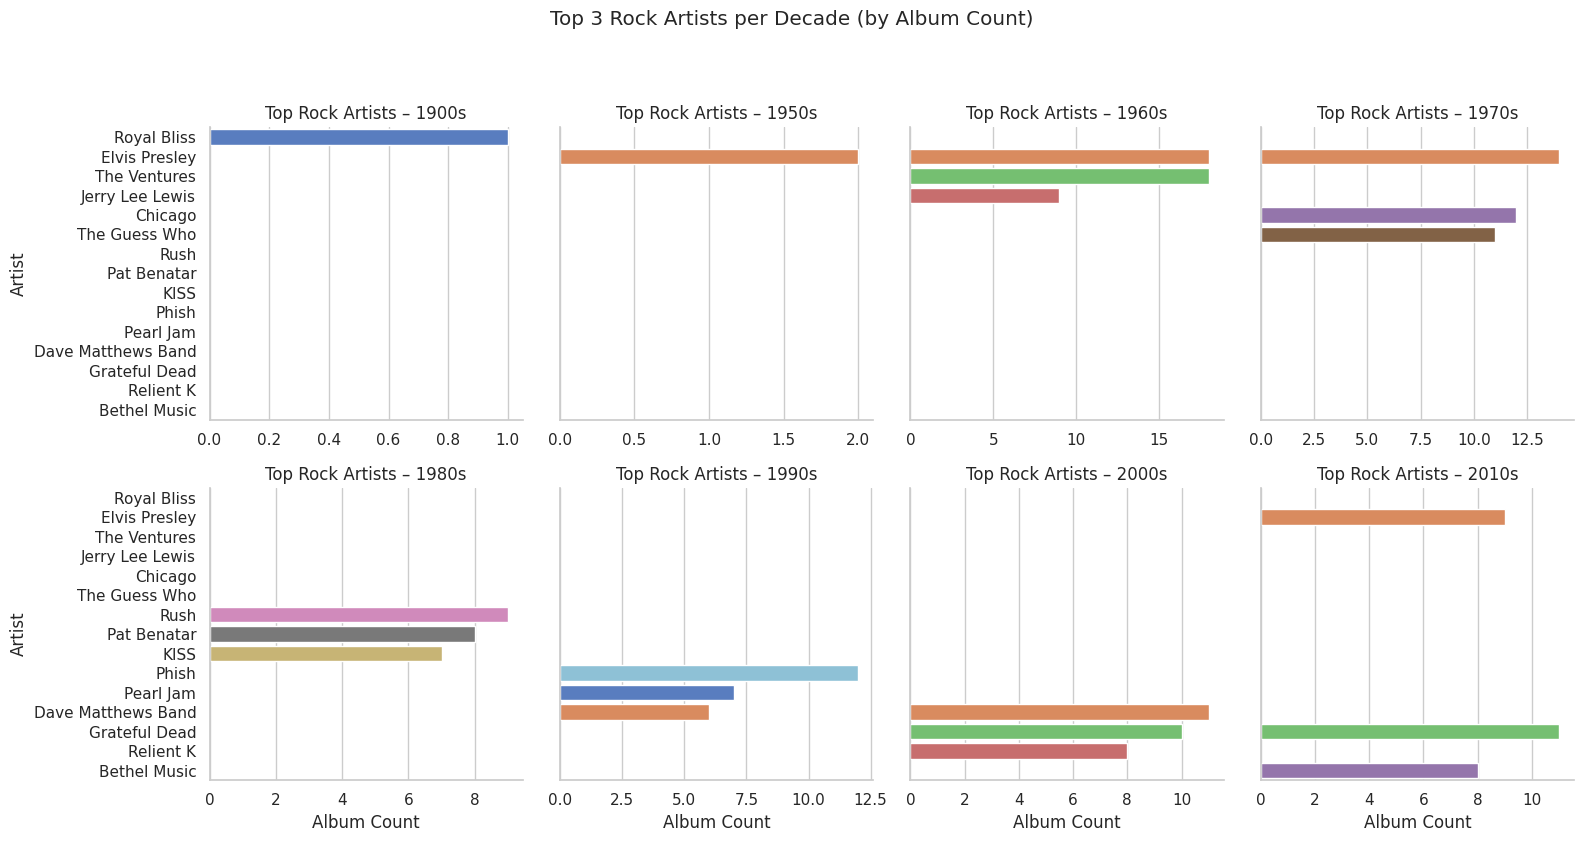

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.catplot(
    data=top_artists_per_decade,
    x='album_count',
    y='artist_name',
    col='decade',
    kind='bar',
    col_wrap=4,
    height=4,
    sharex=False,
    palette='muted'
)

g.set_titles("Top Rock Artists – {col_name}s")
g.set_axis_labels("Album Count", "Artist")
g.fig.suptitle("Top 3 Rock Artists per Decade (by Album Count)", y=1.05)
plt.tight_layout()
plt.show()


In [ ]:
rock_df = trial_df[
    (trial_df['main_genre'] == 'rock') &
    (trial_df['decade'].notna()) &
    (trial_df['subgenre'].notna())
]


In [ ]:
# When each subgenre first appeared in the data
subgenre_first_seen = (
    rock_df.groupby('subgenre')['decade']
    .min()
    .sort_values()
    .reset_index()
    .rename(columns={'decade': 'first_appearance'})
)


In [ ]:
# How many albums per subgenre per decade
subgenre_decade_counts = (
    rock_df[['decade', 'subgenre', 'album_id']]
    .drop_duplicates()
    .groupby(['decade', 'subgenre'])
    .count()
    .reset_index()
    .rename(columns={'album_id': 'album_count'})
)


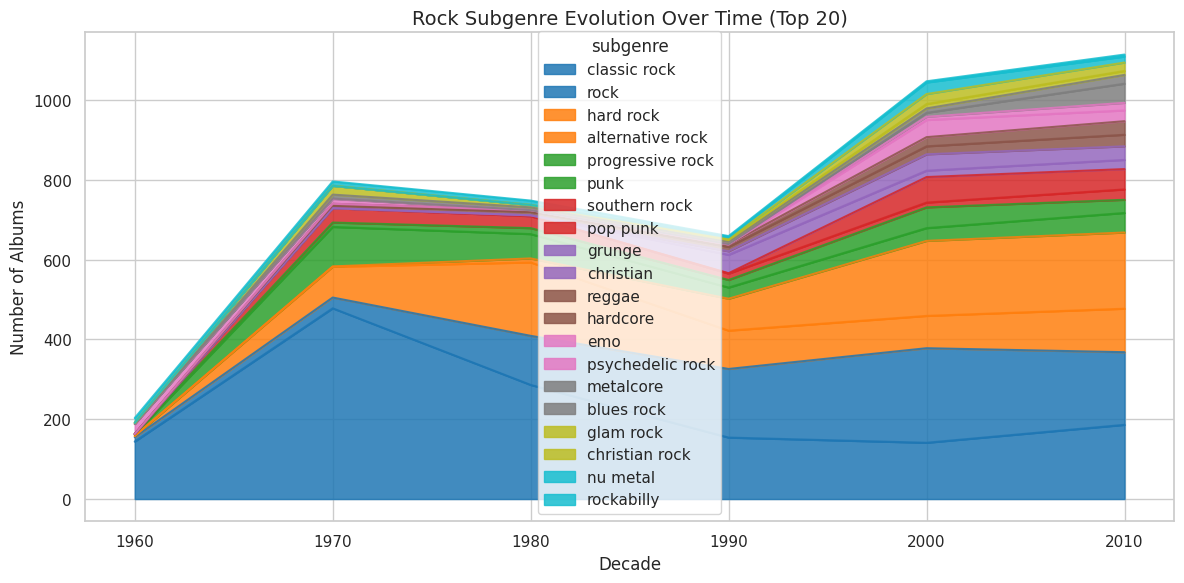

In [ ]:
# Step 1: Define your full decade range (1960–present)
import numpy as np

decades = np.arange(1960, trial_df['decade'].max() + 1, 10)

# Step 2: Pivot the subgenre–decade matrix
pivot_df = subgenre_decade_counts.pivot(index='decade', columns='subgenre', values='album_count').fillna(0)

# Step 3: Filter to top 10 subgenres (optional)
top_subgenres = pivot_df.sum().sort_values(ascending=False).head(20).index
pivot_df = pivot_df[top_subgenres]

# Step 4: Reindex to fill all decades (even if some subgenres had 0s)
pivot_df = pivot_df.reindex(decades).fillna(0)

import matplotlib.pyplot as plt

pivot_df.plot.area(
    stacked=True,
    figsize=(12, 6),
    colormap='tab10',
    alpha=0.85
)

plt.title("Rock Subgenre Evolution Over Time (Top 20)", fontsize=14)
plt.xlabel("Decade")
plt.ylabel("Number of Albums")
plt.xticks(decades)  # Clean, consistent decade ticks
plt.tight_layout()
plt.show()


## Sungenre clusters

##Timeless Artists

In [ ]:
# Exclude generic artists
excluded_artists = ['Various Artists', 'Soundtrack', 'Original Cast']
album_level_df = trial_df[
    ~trial_df['artist_name'].isin(excluded_artists)
][['artist_name', 'decade', 'album_id']].dropna().drop_duplicates()


In [ ]:
# Count unique albums per artist per decade
artist_decade_album_counts = (
    album_level_df
    .groupby(['decade', 'artist_name'])['album_id']
    .nunique()
    .reset_index(name='album_count')
)

# Get top 5 per decade
top_n = 5
top_artists_by_decade = (
    artist_decade_album_counts
    .sort_values(['decade', 'album_count'], ascending=[True, False])
    .groupby('decade')
    .head(top_n)
)


In [ ]:
# Count how many distinct decades each artist appears in
decade_counts = top_artists_by_decade.groupby('artist_name')['decade'].nunique()

# Only keep artists appearing in more than 1 decade
timeless_artists = decade_counts[decade_counts > 1].index

# Filter data to only those timeless artists
timeless_df = top_artists_by_decade[top_artists_by_decade['artist_name'].isin(timeless_artists)]


In [ ]:
# Re-rank artists by how many decades they appeared in
timeless_rank = (
    timeless_df.groupby('artist_name')['decade']
    .nunique()
    .sort_values(ascending=False)
)

artist_order = timeless_rank.index.tolist()
artist_y = {artist: i for i, artist in enumerate(artist_order[::-1])}  # Top at top

timeless_df['y'] = timeless_df['artist_name'].map(artist_y)


/tmp/ipython-input-66-31015280.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeless_df['y'] = timeless_df['artist_name'].map(artist_y)


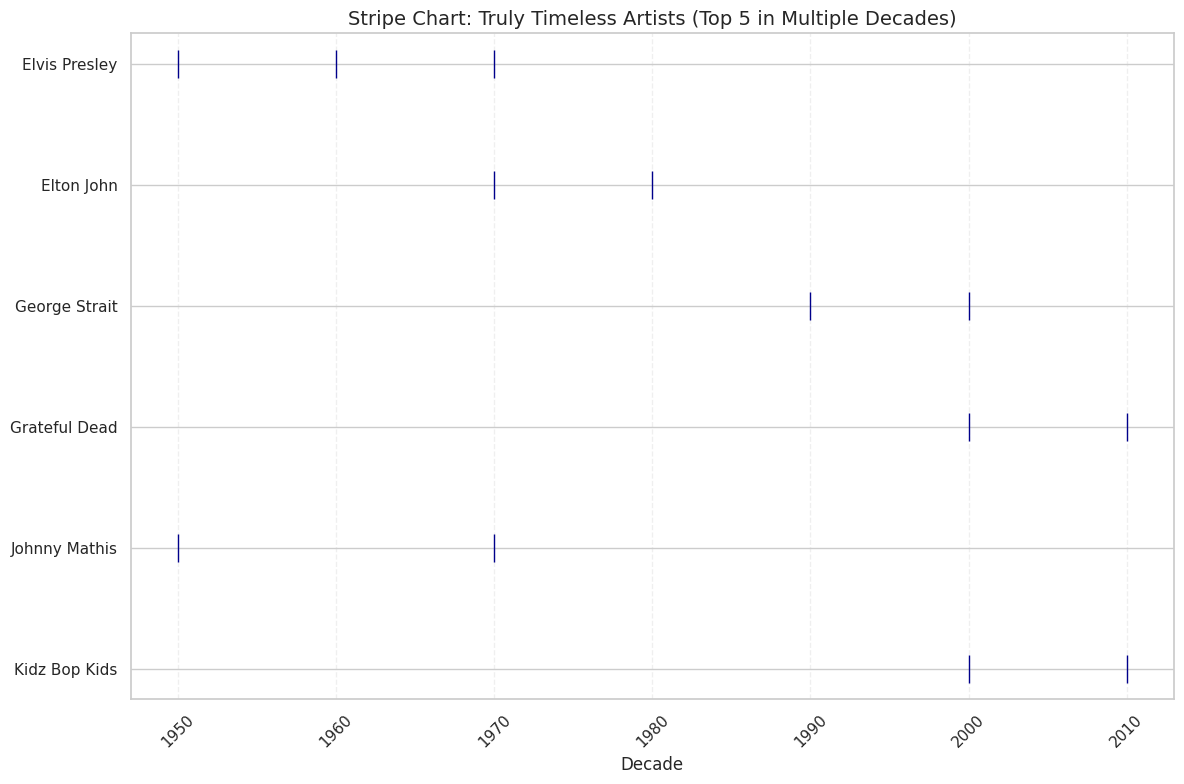

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for _, row in timeless_df.iterrows():
    plt.plot(row['decade'], row['y'], marker='|', markersize=20, color='darkblue')

plt.yticks(list(artist_y.values()), list(artist_y.keys()))
plt.xticks(sorted(timeless_df['decade'].unique()), rotation=45)
plt.xlabel("Decade")
plt.title("Stripe Chart: Truly Timeless Artists (Top 5 in Multiple Decades)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# (If needed) Recompute from album-level data
excluded_artists = ['Various Artists', 'Soundtrack', 'Original Cast']

album_level_df = trial_df[
    ~trial_df['artist_name'].isin(excluded_artists)
][['artist_name', 'main_genre', 'decade', 'album_id']].dropna().drop_duplicates()

# Count albums per artist per genre-decade
artist_genre_decade_counts = (
    album_level_df
    .groupby(['decade', 'main_genre', 'artist_name'])['album_id']
    .nunique()
    .reset_index(name='album_count')
)

# Get top 5 per genre per decade
top_n = 5
top_artists_per_group = (
    artist_genre_decade_counts
    .sort_values(['decade', 'main_genre', 'album_count'], ascending=[True, True, False])
    .groupby(['decade', 'main_genre'])
    .head(top_n)
)


In [ ]:
# Count how many decades each artist appears in within the same genre
artist_genre_decade_counts = (
    top_artists_per_group
    .groupby(['main_genre', 'artist_name'])['decade']
    .nunique()
    .reset_index(name='decade_count')
)

# Keep only artists who appeared in more than one decade within the same genre
genre_timeless = artist_genre_decade_counts[artist_genre_decade_counts['decade_count'] > 1]


In [ ]:
# Merge to keep only timeless rows in top 5 list
timeless_df = top_artists_per_group.merge(
    genre_timeless[['main_genre', 'artist_name']],
    on=['main_genre', 'artist_name'],
    how='inner'
)


In [ ]:
# Rank by number of genre-decade appearances
ranked_artists = (
    timeless_df.groupby('artist_name')['decade']
    .nunique()
    .sort_values(ascending=False)
    .index.tolist()
)

# Assign y positions
artist_y = {artist: i for i, artist in enumerate(ranked_artists[::-1])}
timeless_df['y'] = timeless_df['artist_name'].map(artist_y)


/tmp/ipython-input-78-2611539003.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeless_df_top10['y'] = timeless_df_top10['artist_name'].map(artist_y)


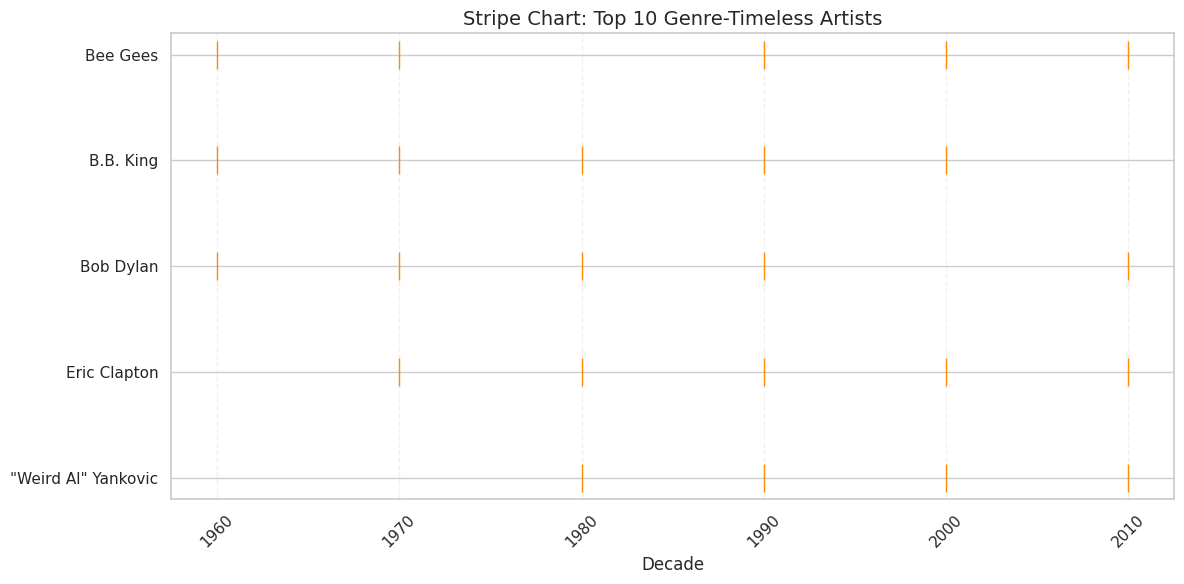

In [ ]:
# Count how many decades each artist appeared in (from previous timeless_df)
artist_decade_counts = (
    timeless_df.groupby('artist_name')['decade']
    .nunique()
    .sort_values(ascending=False)
)

# Get top 10
top_10_artists = artist_decade_counts.head(5).index.tolist()

timeless_df_top10 = timeless_df[timeless_df['artist_name'].isin(top_10_artists)]

# Re-rank the top 10 artists for the y-axis
artist_y = {artist: i for i, artist in enumerate(top_10_artists[::-1])}
timeless_df_top10['y'] = timeless_df_top10['artist_name'].map(artist_y)


plt.figure(figsize=(12, 6))

for _, row in timeless_df_top10.iterrows():
    plt.plot(row['decade'], row['y'], marker='|', markersize=20, color='darkorange')

plt.yticks(list(artist_y.values()), list(artist_y.keys()))
plt.xticks(sorted(timeless_df_top10['decade'].unique()), rotation=45)
plt.xlabel("Decade")
plt.title("Stripe Chart: Top 10 Genre-Timeless Artists", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


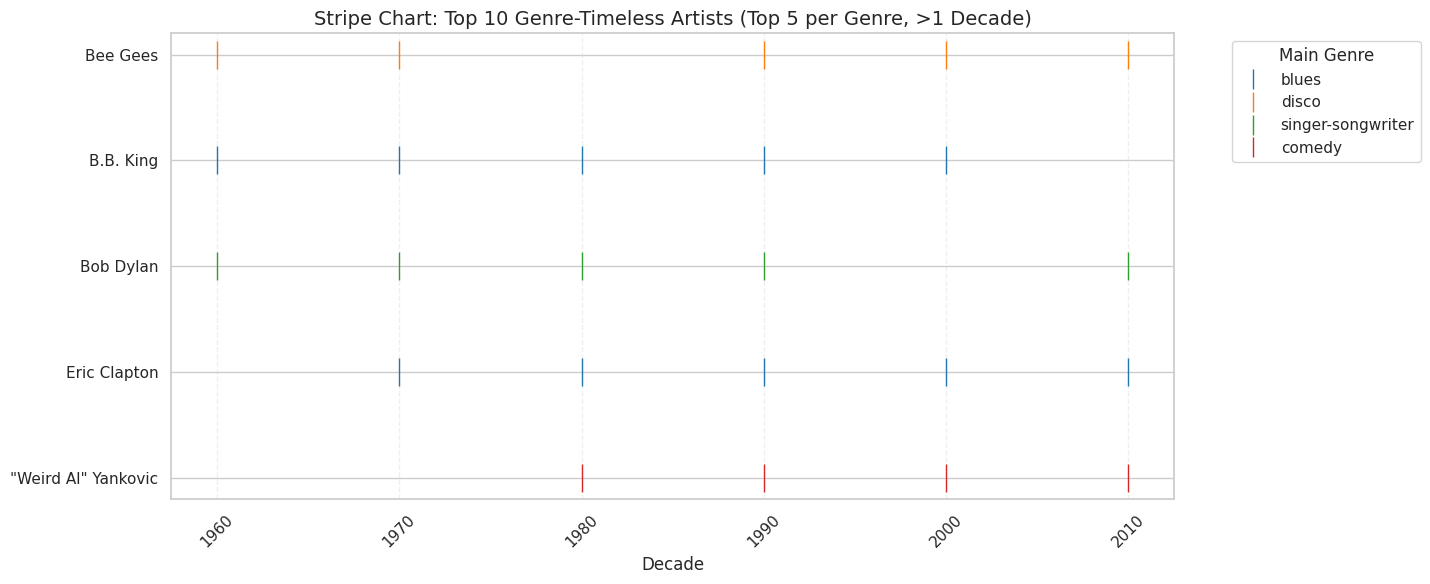

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Choose a color for each genre
unique_genres = timeless_df_top10['main_genre'].unique()
palette = sns.color_palette("tab10", len(unique_genres))
genre_colors = dict(zip(unique_genres, palette))

# Step 2: Plot
plt.figure(figsize=(12, 6))

for _, row in timeless_df_top10.iterrows():
    color = genre_colors[row['main_genre']]
    plt.plot(row['decade'], row['y'], marker='|', markersize=20, color=color)

plt.yticks(list(artist_y.values()), list(artist_y.keys()))
plt.xticks(sorted(timeless_df_top10['decade'].unique()), rotation=45)
plt.xlabel("Decade")
plt.title("Stripe Chart: Top 10 Genre-Timeless Artists (Top 5 per Genre, >1 Decade)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Step 3: Add genre legend
handles = [plt.Line2D([0], [0], marker='|', linestyle='', color=genre_colors[g], markersize=15, label=g)
           for g in genre_colors]
plt.legend(handles=handles, title="Main Genre", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Genre Evolution

In [ ]:
unique_main_genres = trial_df['main_genre'].dropna().unique()
unique_main_genres = sorted(trial_df['main_genre'].dropna().unique())
print(unique_main_genres)


['adult standards', 'big band', 'blues', 'children', 'classical', 'comedy', 'corrido', 'country', 'disco', 'edm', 'exotica', 'experimental', 'freestyle', 'funk', 'gospel', 'grime', 'hip hop', 'holiday', 'horrorcore', 'indie', 'jazz', 'latin', 'metal', 'minimalism', 'new age', 'new wave', 'newgrass', 'pop', 'quiet storm', 'r&b', 'ragtime', 'rock', 'singer-songwriter', 'soul', 'soundtrack', 'spoken word', 'swing', 'trip hop', 'world']


In [ ]:
trial_df.head()

id               song       album  \
0  0Veyvc3n9AcLSoK3r1dA12  Voices In My Head  Hoodie SZN   
1  0Veyvc3n9AcLSoK3r1dA12  Voices In My Head  Hoodie SZN   
2  77JzXZonNumWsuXKy9vr3U             Beasty  Hoodie SZN   
3  77JzXZonNumWsuXKy9vr3U             Beasty  Hoodie SZN   
4  18yllZD0TdF7ykcREib8Z1           I Did It  Hoodie SZN   

              artist_name  acousticness  danceability  duration_ms  energy  \
0  A Boogie Wit da Hoodie        0.0555         0.754     142301.0   0.663   
1  A Boogie Wit da Hoodie        0.0555         0.754     142301.0   0.663   
2  A Boogie Wit da Hoodie        0.2920         0.860     152829.0   0.418   
3  A Boogie Wit da Hoodie        0.2920         0.860     152829.0   0.418   
4  A Boogie Wit da Hoodie        0.1530         0.718     215305.0   0.454   

   instrumentalness  key  ...       date               artist_id  explicit  \
0          0.000000  6.0  ... 2018-12-21  31W5EY0aAly4Qieq6OFu6I      True   
1          0.000000  6.0  ... 2018-12-21  31W5EY0aAly4Qieq6OFu6I      True   
2          0.000000  7.0  ... 2018-12-21  31W5EY0aAly4Qieq6OFu6I      True   
3          0.000000  7.0  ... 2018-12-21  31W5EY0aAly4Qieq6OFu6I      True   
4          0.000046  8.0  ... 2018-12-21  31W5EY0aAly4Qieq6OFu6I      True   

   available_markets_count  featured_track  featured_artists  main_genre  \
0                    185.0           False               NaN     hip hop   
1                    185.0           False               NaN     hip hop   
2                    185.0           False               NaN     hip hop   
3                    185.0           False               NaN     hip hop   
4                    185.0           False               NaN     hip hop   

      subgenre  year decade  
0          rap  2018   2010  
1  melodic rap  2018   2010  
2          rap  2018   2010  
3  melodic rap  2018   2010  
4          rap  2018   2010  

[5 rows x 28 columns]

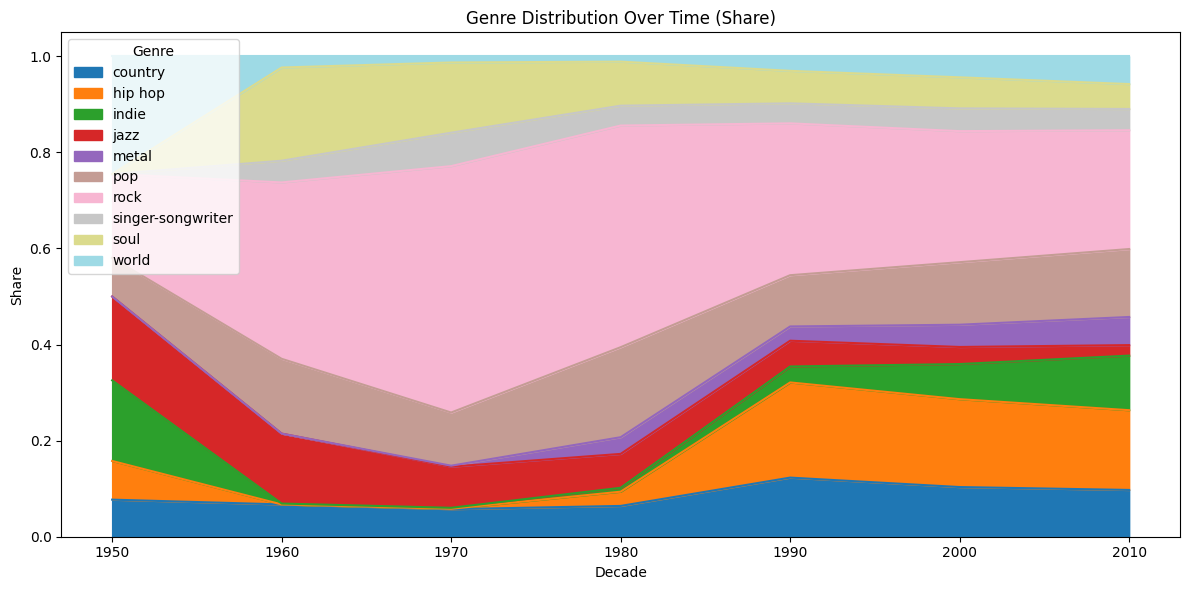

In [ ]:

genre_trend = genre_decade.pivot(index='decade', columns='main_genre', values='count').fillna(0)
genre_share = genre_trend.div(genre_trend.sum(axis=1), axis=0)

# Plot
genre_share.plot.area(figsize=(12, 6), cmap='tab20')
plt.title('Genre Distribution Over Time (Share)')
plt.xlabel('Decade')
plt.ylabel('Share')
plt.legend(title='Genre', loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import altair as alt

# Altair needs year to be a string for animation
genre_year['year'] = genre_year['year'].astype(str)

# Filter top genres (optional)
top_genres = genre_year.groupby('main_genre')['album_count'].sum().nlargest(8).index
df_filtered = genre_year[genre_year['main_genre'].isin(top_genres)]

# Build chart
chart = alt.Chart(df_filtered).mark_bar().encode(
    x=alt.X('album_count:Q', title='Album Count'),
    y=alt.Y('main_genre:N', sort='-x'),
    color='main_genre:N',
).properties(
    width=600,
    height=400
).encode(
    tooltip=['main_genre', 'album_count']
).interactive().facet(
    column=alt.Column('year:N', title='Year')
).resolve_scale(
    y='independent'
)

chart


alt.FacetChart(...)

In [ ]:
# Make sure 'decade' is calculated
trial_df['decade'] = (trial_df['year'] // 10) * 10

# Drop duplicates to work at the album level
df_album = trial_df[['album_id', 'main_genre', 'decade']].dropna().drop_duplicates()

# Group by decade and genre (album counts)
genre_decade = df_album.groupby(['decade', 'main_genre']).size().reset_index(name='album_count')


In [ ]:
# Normalize album counts by total per decade to get share
genre_decade['total_decade'] = genre_decade.groupby('decade')['album_count'].transform('sum')
genre_decade['share'] = genre_decade['album_count'] / genre_decade['total_decade']


In [ ]:
import plotly.express as px

fig = px.area(
    genre_decade,
    x='decade',
    y='share',
    color='main_genre',
    line_group='main_genre',
    title='Main Genre Popularity Over Decades (Normalized by Album)',
    labels={'share': 'Share of Albums', 'decade': 'Decade'},
    category_orders={'decade': sorted(genre_decade['decade'].unique())}
)

fig.update_layout(
    xaxis=dict(type='category'),
    yaxis=dict(tickformat=".0%", title='Normalized Share'),
    legend_title_text='Main Genre',
    height=600
)

fig.show()


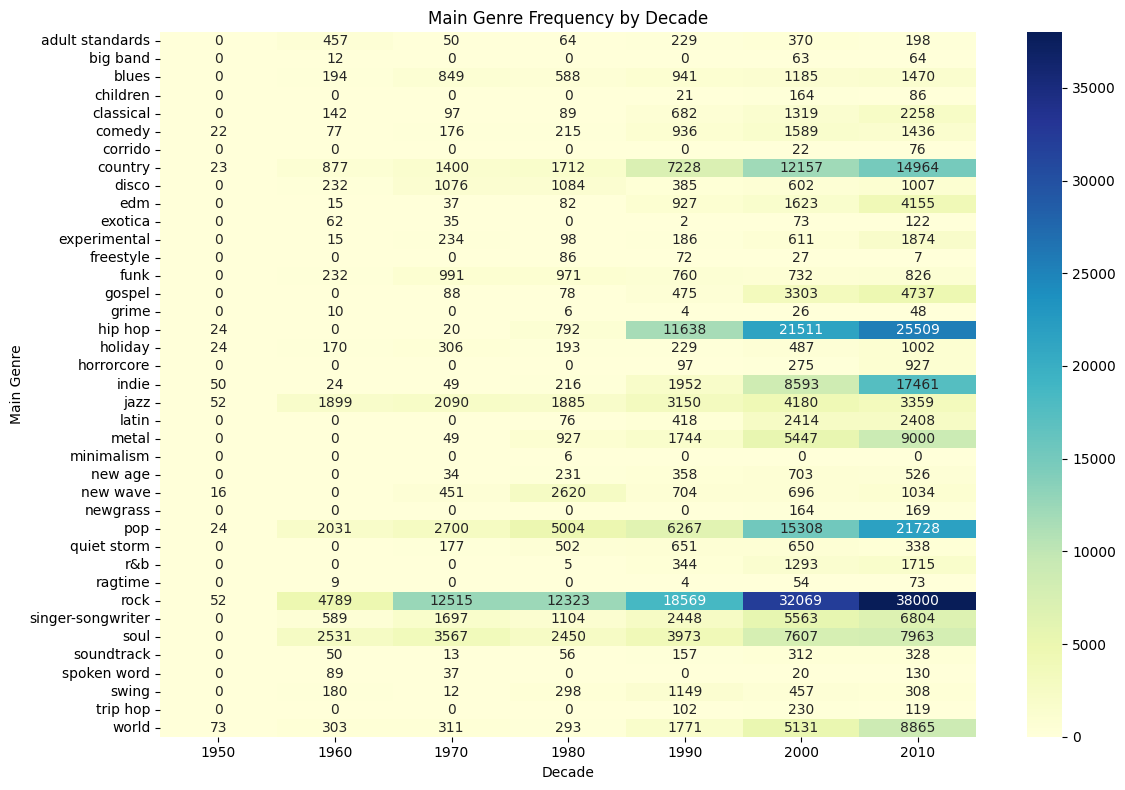

In [ ]:
import seaborn as sns
# Count how often each main genre appears in each decade
genre_counts = trial_df.groupby(['decade', 'main_genre']).size().reset_index(name='count')
# Create a matrix with main genres as rows and decades as columns
heat_df = genre_counts.pivot(index='main_genre', columns='decade', values='count').fillna(0)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heat_df, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title("Main Genre Frequency by Decade")
plt.xlabel("Decade")
plt.ylabel("Main Genre")
plt.tight_layout()
plt.show()


In [ ]:
from itertools import combinations
from collections import Counter

# Step 1: for each decade, get the set of unique main genres
genre_pairs = []

for decade in trial_df['decade'].dropna().unique():
    decade_genres = trial_df[trial_df['decade'] == decade]['main_genre'].dropna().unique()
    # Create all unique pairs
    for g1, g2 in combinations(sorted(decade_genres), 2):
        genre_pairs.append((g1, g2))

# Step 2: count how often each pair occurred
pair_counts = Counter(genre_pairs)

# Step 3: convert to DataFrame
chord_df = pd.DataFrame([(a, b, c) for (a, b), c in pair_counts.items()],
                        columns=['source', 'target', 'value'])


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
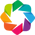

:Chord   [source,target]   (value)

In [ ]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

chord = hv.Chord(chord_df).opts(
    opts.Chord(
        labels='source',
        edge_color='source',
        node_color='source',
        cmap='Category20',
        width=700,
        height=700,
        title='Main Genre Co-occurrence Network'  # or Subgenre Shared Bridge
    )
)

chord


In [ ]:
# Drop missing
df = trial_df[['main_genre', 'subgenre']].dropna().drop_duplicates()

# Step 1: find subgenres mapped to multiple main genres
multi_main_subs = df.groupby('subgenre')['main_genre'].nunique()
shared_subs = multi_main_subs[multi_main_subs > 1].index

# Step 2: build edges between main genres via shared subgenre
pair_links = []

for sub in shared_subs:
    mains = df[df['subgenre'] == sub]['main_genre'].unique()
    for g1, g2 in combinations(sorted(mains), 2):
        pair_links.append((g1, g2))

# Step 3: count links
shared_links = Counter(pair_links)
chord_df = pd.DataFrame([(a, b, c) for (a, b), c in shared_links.items()],
                        columns=['source', 'target', 'value'])


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
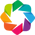

:Chord   [source,target]   (value)

In [ ]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

chord = hv.Chord(chord_df).opts(
    opts.Chord(
        labels='source',
        edge_color='source',
        node_color='source',
        cmap='Category20',
        width=700,
        height=700,
        title='Main Genre Co-occurrence Network'  # or Subgenre Shared Bridge
    )
)

chord


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Assume df is already loaded
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/acoustic_features_with_gender_musicbrainz.csv'
# ------------------------
# Step 1: Load data
# ------------------------
df = pd.read_csv(path)
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Assume df is already loaded
# ---------------------------

# Convert date to datetime, clean and filter
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'genres', 'gender'])
df = df[df['gender'].str.lower().isin(['male', 'female'])]

df['decade'] = (df['date'].dt.year // 10) * 10
df = df[df['decade'] >= 1960]

# Top 5 genres
top5_genres = df['genres'].value_counts().nlargest(5).index.tolist()
df_top = df[df['genres'].isin(top5_genres)]

# Grouping
grouped = df_top.groupby(['decade', 'genres', 'gender']).size().unstack(fill_value=0).reset_index()

# Pivot by genre
pivoted = {}
for genre in top5_genres:
    genre_data = grouped[grouped['genres'] == genre].set_index('decade')[['male', 'female']]
    pivoted[genre] = genre_data

# ---------------------------
# Plotting
# ---------------------------
fig, ax = plt.subplots(figsize=(16, 7))
bar_width = 0.8
bar_spacing = 1.2
decades = sorted(df['decade'].unique())
x_labels = []
x_positions = []
colors = {'male': 'steelblue', 'female': 'lightcoral'}

# Draw bars
for i, decade in enumerate(decades):
    base_x = i * (len(top5_genres) * bar_spacing + 1)  # Add margin
    for j, genre in enumerate(top5_genres):
        data = pivoted[genre]
        x = base_x + j * bar_spacing
        x_positions.append(x)

        if decade in data.index:
            male_count = data.loc[decade, 'male']
            female_count = data.loc[decade, 'female']
        else:
            male_count = female_count = 0

        ax.bar(x, male_count, width=bar_width, color=colors['male'])
        ax.bar(x, female_count, bottom=male_count, width=bar_width, color=colors['female'])
        x_labels.append(genre)

    # Add vertical line to separate decades
    if i > 0:
        ax.axvline(base_x - bar_spacing / 2, color='gray', linestyle='--', alpha=0.5)

    # Optional: Background shading
    if i % 2 == 0:
        ax.axvspan(base_x - bar_spacing / 2, base_x + len(top5_genres) * bar_spacing, color='lightgray', alpha=0.1)

# X-ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Decade labels below bars
for i, decade in enumerate(decades):
    block_center = i * (len(top5_genres) * bar_spacing + 1) + (len(top5_genres) * bar_spacing / 2)
    ax.text(block_center, -max(df_top['gender'].value_counts()) * 0.05, str(decade), ha='center', fontsize=11, weight='bold')



import matplotlib.patches as mpatches



# Final formatting
ax.set_title("Male vs Female Artist Distribution in Top 5 Genres by Decade (Since 1960)", fontsize=14)
ax.set_ylabel("Number of Artists")
ax.set_xlabel("Genres per Decade")
ax.legend(['Male', 'Female'], title='Gender')
ax.grid(axis='y', linestyle='--', alpha=0.4)
# Create custom legend patches
male_patch = mpatches.Patch(color='steelblue', label='Male')
female_patch = mpatches.Patch(color='lightcoral', label='Female')

# Display correct legend
plt.legend(handles=[male_patch, female_patch], title='Gender')

plt.tight_layout()
plt.show()